### Import Libraries

In [3949]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import folium
from scipy import stats
from scipy.stats import spearmanr
import scikit_posthocs as sp
from scipy.stats import kruskal

### Load Dataset and Check Details

In [3950]:
# read csv file and save into dataframe df
df = pd.read_csv("Airbnb Listings Bangkok.csv")
# df.head()

In [3951]:
# basic dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      15854 non-null  int64  
 1   id                              15854 non-null  int64  
 2   name                            15846 non-null  object 
 3   host_id                         15854 non-null  int64  
 4   host_name                       15853 non-null  object 
 5   neighbourhood                   15854 non-null  object 
 6   latitude                        15854 non-null  float64
 7   longitude                       15854 non-null  float64
 8   room_type                       15854 non-null  object 
 9   price                           15854 non-null  int64  
 10  minimum_nights                  15854 non-null  int64  
 11  number_of_reviews               15854 non-null  int64  
 12  last_review                     

### Cleaning Dataset

In [3952]:
# dropping redundant unnamed column
df = df.drop(columns=["Unnamed: 0"])
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaN,NaN,2,358,0
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaN,NaN,1,365,0
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaN,NaN,3,365,0


In [3953]:
# find duplicates and handle accordingly
df.duplicated().sum()
# no duplicates

np.int64(0)

In [3954]:
# find missing values and handle accordingly
df.isnull().sum()

id                                   0
name                                 8
host_id                              0
host_name                            1
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       5790
reviews_per_month                 5790
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
dtype: int64

In [3955]:
# check name column missing values
# df[df["name"].isna()]

In [3956]:
# since name are descrptive titles, replace them with placeholder value of "Unknown"
# df["name"].fillna("Unknown", inplace=True)
df.fillna({"name": "Unknown"}, inplace=True)

In [3957]:
# double check name column missing values
# df[df["name"].isna()]
# no more name column missing values

In [3958]:
# check host_name column missing values
# df[df["host_name"].isna()]

In [3959]:
# since host_name is not too important in the analysis, replace them with placeholder value of "Unknown"
df.fillna({"host_name": "Unknown"}, inplace=True)

In [3960]:
# double check host_name column missing values
# df[df["host_name"].isna()]
# no more host_name column missing values

In [3961]:
# check last_review and reviews_per_month column
# df[df["last_review"].isna() & df["reviews_per_month"].isna()]
# 5790 missing values --> equal

In [3962]:
# len(df[df["number_of_reviews"] == 0])

In [3963]:
# last_review column has 5790 missing values
# reviews_per_month column has 5790 missing values
# above shows 5790 missing values --> btoh last_review and reviews_per_month column falls under the same rows
# last_review can be replaced with placeholder value of "No review" --> since last_review is an object format
# reviews_per_month can be replaced with 0 (no last_review means no reviews were made in any month)

df.fillna({"last_review": "No Review"}, inplace=True)
df.fillna({"reviews_per_month": 0}, inplace=True)

In [3964]:
# double check last_review and reviews_per_month column
# df[df["last_review"].isna() & df["reviews_per_month"].isna()]
# no more missing values

In [3965]:
# double check all columns for missing values
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

Dataset information after cleaning values

In [3966]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.585400e+04,1.585400e+04,15854.000000,15854.000000,1.585400e+04,15854.000000,15854.000000,15854.000000,15854.000000,15854.000000,15854.000000
mean,1.579397e+17,1.541058e+08,13.745144,100.559903,3.217704e+03,15.292355,16.654157,0.516178,13.889618,244.378643,3.481519
std,2.946015e+17,1.318726e+08,0.043040,0.050911,2.497212e+04,50.815020,40.613331,0.952753,30.269848,125.843224,8.916937
min,2.793400e+04,5.892000e+04,13.527300,100.329550,0.000000e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.104509e+07,3.974431e+07,13.720090,100.529690,9.000000e+02,1.000000,0.000000,0.000000,1.000000,138.000000,0.000000
50%,3.503734e+07,1.224556e+08,13.738490,100.561415,1.429000e+03,1.000000,2.000000,0.090000,4.000000,309.000000,0.000000
75%,5.256154e+07,2.390547e+08,13.759497,100.585150,2.429000e+03,7.000000,13.000000,0.670000,13.000000,360.000000,3.000000
max,7.908162e+17,4.926659e+08,13.953540,100.923440,1.100000e+06,1125.000000,1224.000000,19.130000,228.000000,365.000000,325.000000


# Main Topic
Price Recommendation

In [3967]:
# number of different neighbourhood
df["neighbourhood"].nunique()

50

In [3968]:
# number of different room_type
df["room_type"].nunique()

4

- want to check the difference in prices between the different types of rooms in different neighbourhoods
- logically, the different types of rooms would have different pricings

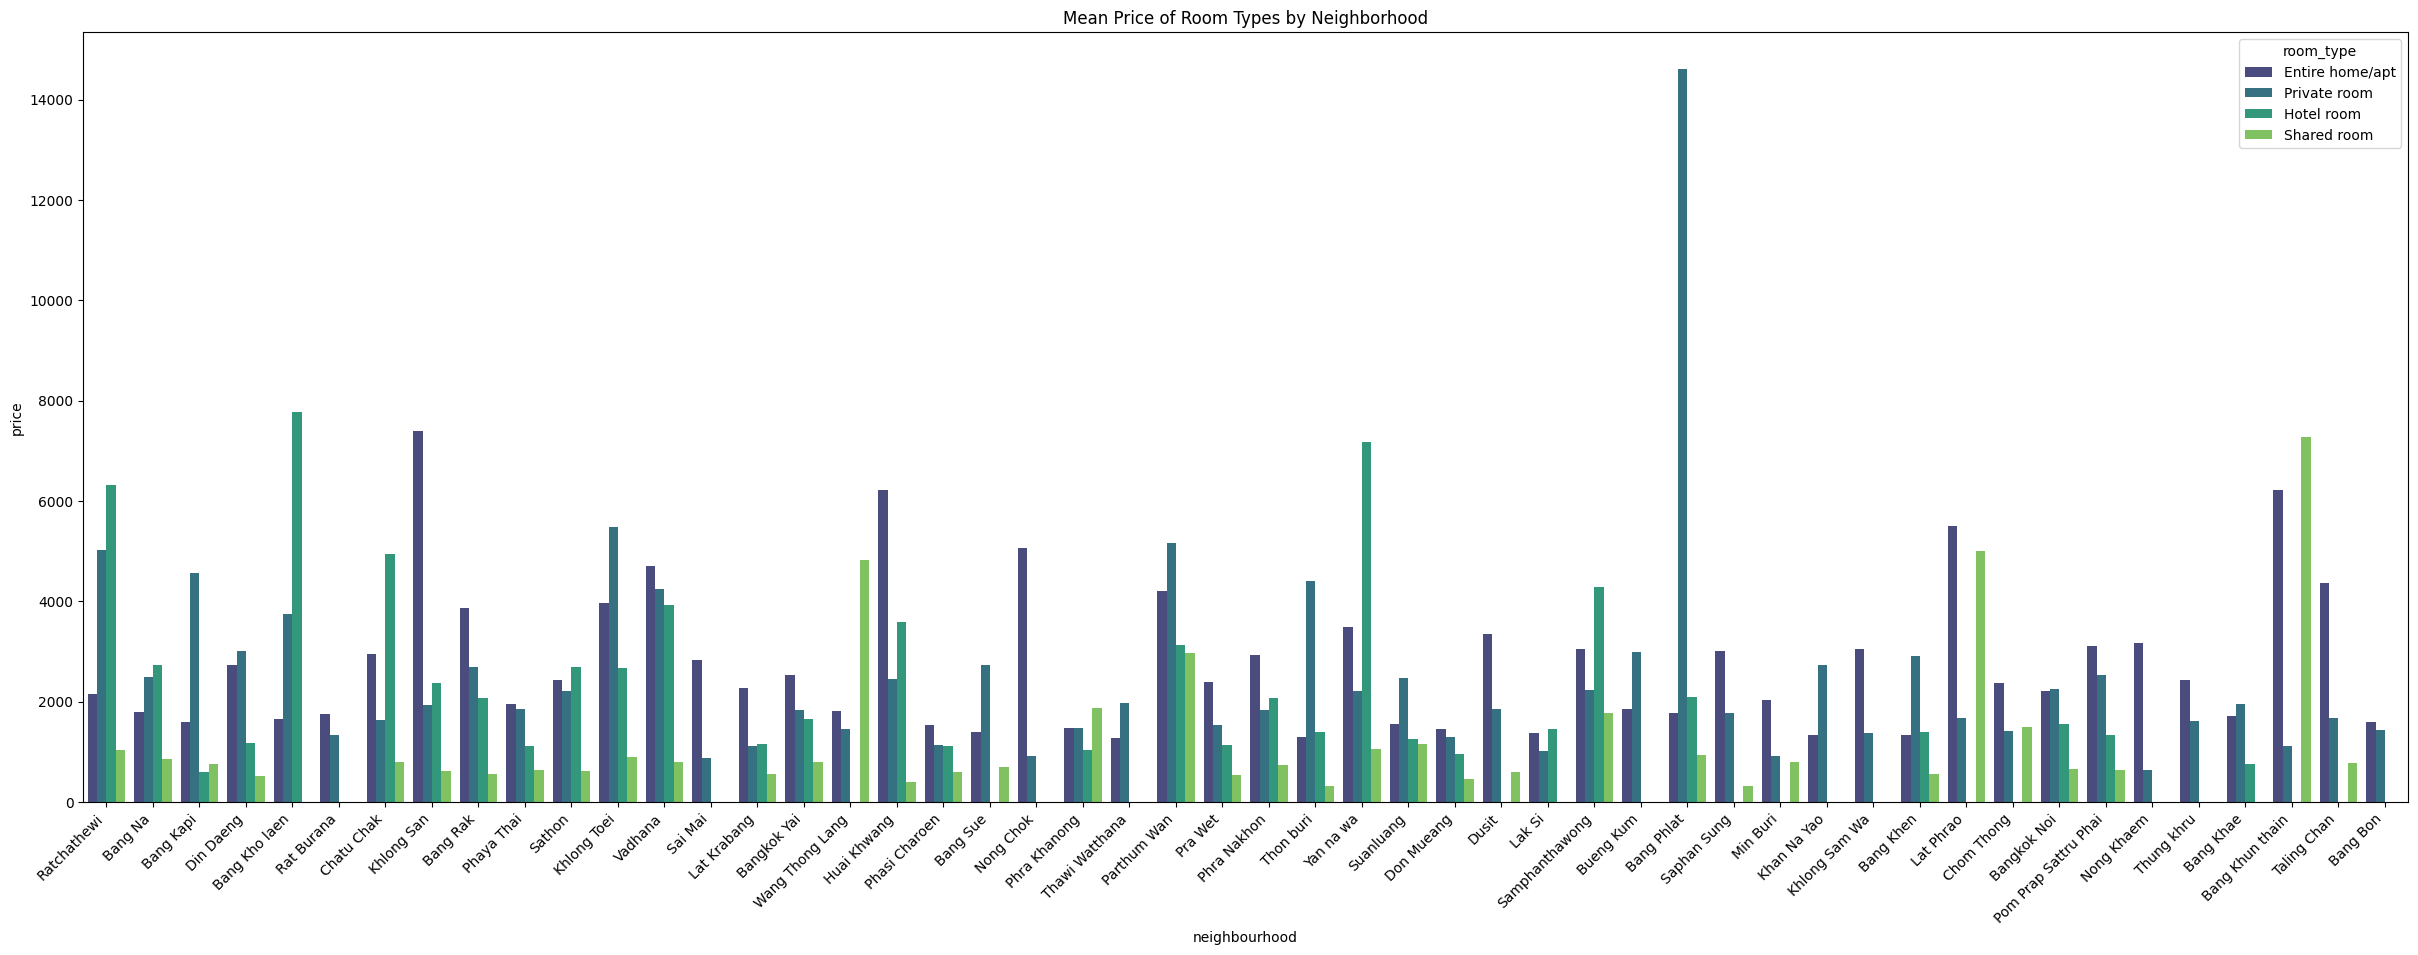

In [3969]:
# create graph to see the mean prices of each room_type in each neighbourhood
plt.figure(figsize=(30, 10))
sns.barplot(x = "neighbourhood", y = "price", data = df, hue = "room_type", estimator=np.mean, errorbar= None, palette="viridis")
plt.title("Mean Price of Room Types by Neighborhood")
plt.xticks(rotation=45, ha="right");

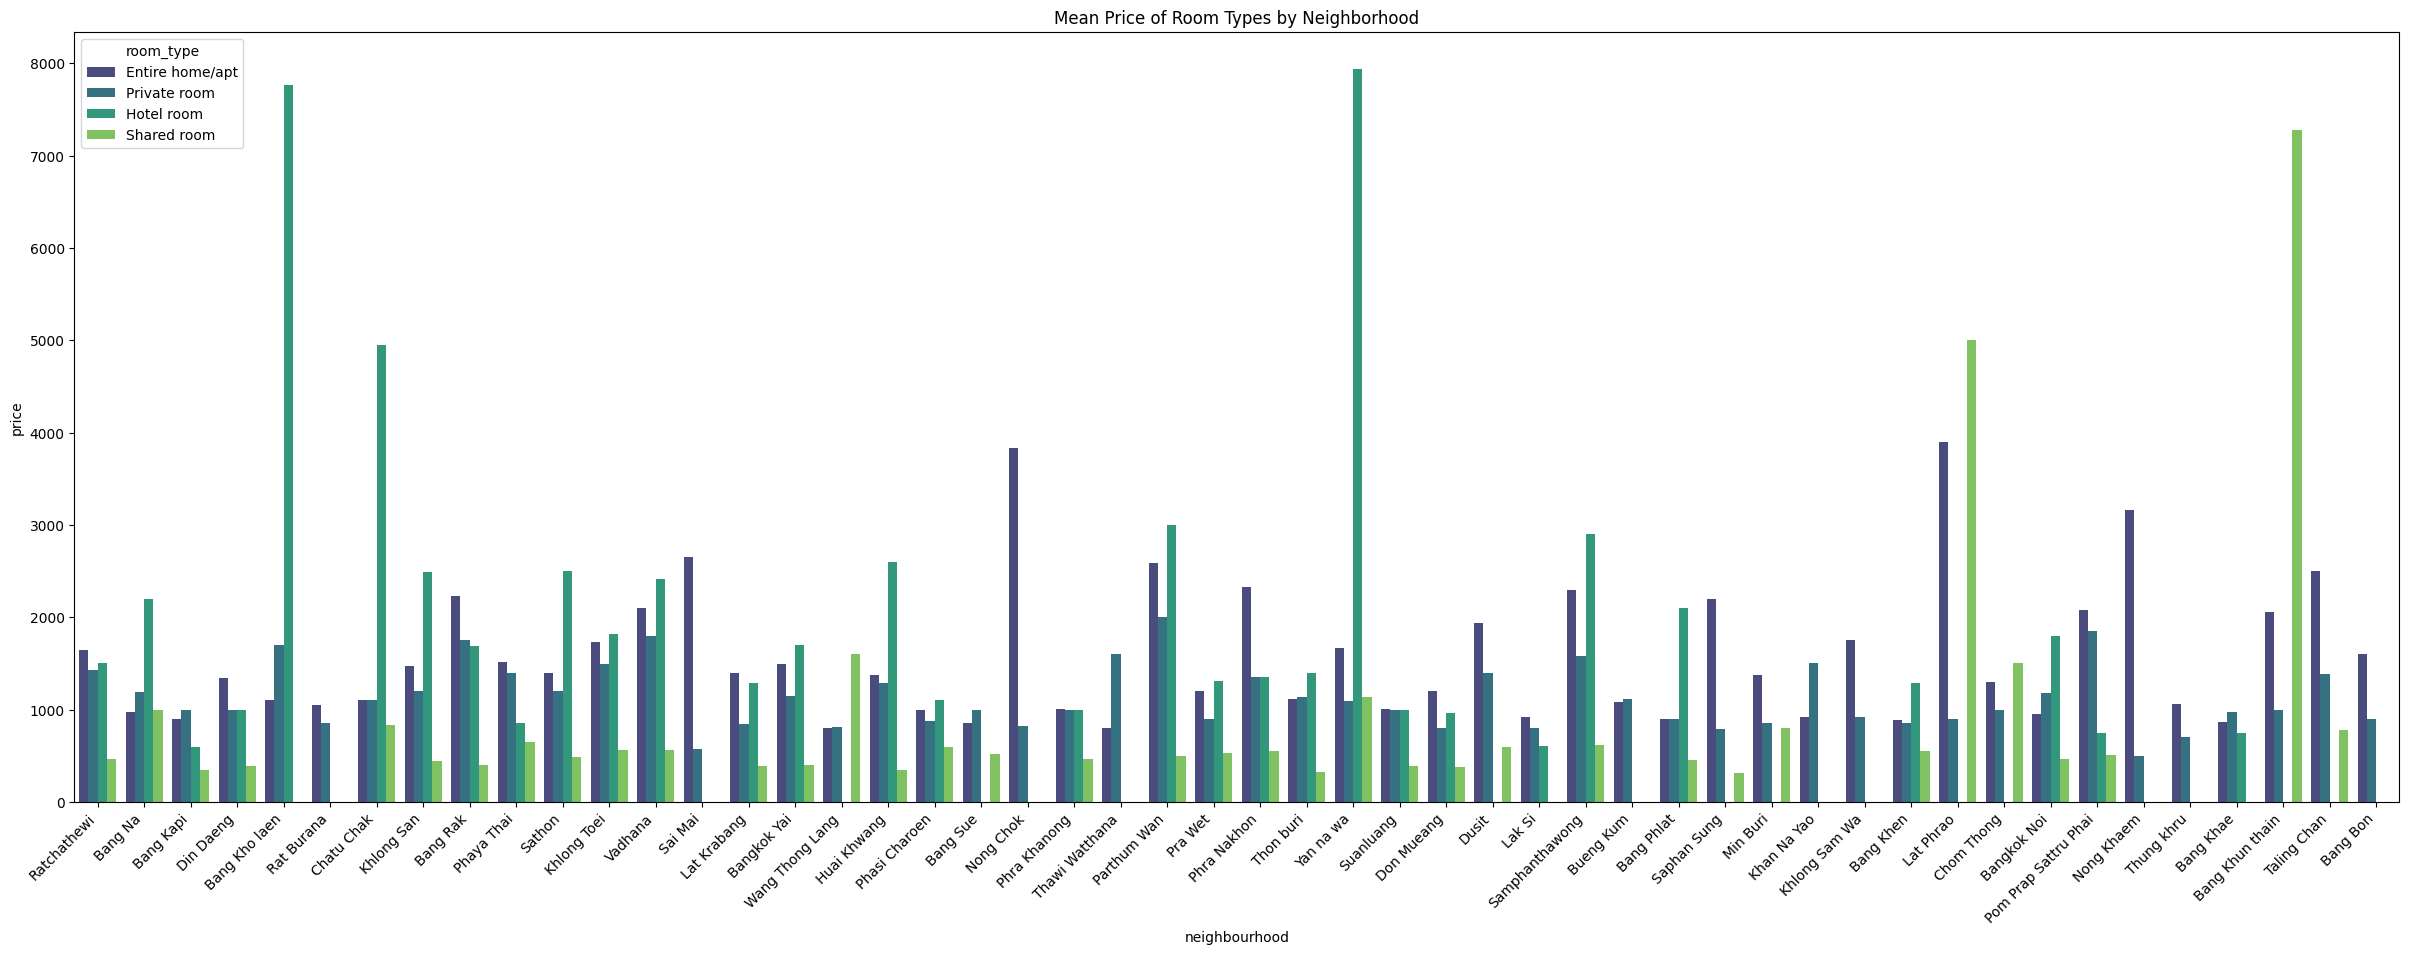

In [3970]:
# create graph to see the median prices of each room_type in each neighbourhood
plt.figure(figsize=(30, 10))
sns.barplot(x = "neighbourhood", y = "price", data = df, hue = "room_type", estimator=np.median, errorbar= None, palette="viridis")
plt.title("Mean Price of Room Types by Neighborhood")
plt.xticks(rotation=45, ha="right");

- too many neighbourhoods --> difficult to visualise
- separate into different zones based on neighbourhood median longitude & latitude
- central, northeast, northwest, southeast, southwest

In [3971]:
neighborhood_medians = df.groupby("neighbourhood")[["latitude", "longitude"]].median().reset_index()
# neighborhood_medians

In [3972]:
# find the median of latitude and longitude separately
median_lat = df["latitude"].median()   
median_lon = df["longitude"].median()  

# create function to assign regions based on lat lon
def assign_region(lat, lon):

    lat_q1, lat_q3 = df["latitude"].quantile([0.25, 0.75])
    lon_q1, lon_q3 = df["longitude"].quantile([0.25, 0.75])
    iqr_lat = lat_q3 - lat_q1
    iqr_lon = lon_q3 - lon_q1
    
    # Adjust Central Region
    central_lat_min = lat_q1
    central_lat_max = lat_q3
    central_lon_min = lon_q1
    central_lon_max = lon_q3
    
    if central_lat_min <= lat <= central_lat_max and central_lon_min <= lon <= central_lon_max: # central area range
        return "Central"
    elif lat >= median_lat and lon > median_lon:
        return "Northeast"
    elif lat >= median_lat and lon <= median_lon:
        return "Northwest"
    elif lat < median_lat and lon > median_lon:
        return "Southeast"
    elif lat < median_lat and lon <= median_lon:
        return "Southwest"

In [3973]:
neighborhood_medians["region"] = neighborhood_medians.apply(
    lambda row: assign_region(row["latitude"], row["longitude"]), axis=1
)

In [3974]:
df = df.merge(neighborhood_medians[["neighbourhood", "region"]], on="neighbourhood", how="left")
# df.head()

In [3975]:
# check number of entries for each region
df["region"].value_counts()

region
Central      5819
Northeast    3245
Southwest    3151
Northwest    1936
Southeast    1703
Name: count, dtype: int64

In [3976]:
df["neighbourhood"].value_counts()

neighbourhood
Vadhana                 2153
Khlong Toei             2097
Huai Khwang             1125
Ratchathewi             1114
Bang Rak                 827
Sathon                   809
Phra Nakhon              619
Phra Khanong             558
Chatu Chak               548
Bang Na                  458
Parthum Wan              455
Din Daeng                444
Phaya Thai               422
Suanluang                382
Khlong San               357
Bang Kapi                260
Bang Sue                 250
Bang Phlat               217
Yan na wa                200
Thon buri                182
Don Mueang               167
Pra Wet                  156
Phasi Charoen            155
Bangkok Noi              152
Lat Krabang              149
Bang Kho laen            140
Lak Si                   126
Pom Prap Sattru Phai     123
Bang Khen                116
Samphanthawong           114
Wang Thong Lang          100
Bang Khae                 92
Dusit                     91
Bangkok Yai               90


### Map of Airbnb Listings in Bangkok Based on Regions Created

In [3977]:
# Define a color mapping for your regions
region_colors = {
    "Central": "red",
    "Northeast": "blue",
    "Southwest": "green",
    "Northwest": "purple",
    "Southeast": "orange"
}

# Create a base map centered around the average coordinates
map_center = [df["latitude"].mean(), df["longitude"].mean()]
bangkok_airbnb = folium.Map(location=map_center, zoom_start=12)

# Add points for each listing
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=region_colors.get(row["region"], "black"),
        fill=True,
        fill_color=region_colors.get(row["region"], "black"),
        fill_opacity=0.6,
    ).add_to(bangkok_airbnb)

# Show the map
# bangkok_airbnb

In [3978]:
df["room_type"].value_counts()

room_type
Entire home/apt    8912
Private room       5770
Hotel room          649
Shared room         523
Name: count, dtype: int64

### Recategorizing Miscategorization of Room Types

In [3979]:
# list keywords to access the name column
eha_keywords = ["house", "home", "apartment", "apt", "condo", "villa"] # keywords for entire home/apt
hr_keywords = ["hotel"]    # keywords for hotel room
sr_keywords = ["dorm", "hostel", "capsule"] # keywords for shared room
# private room will logically be the rest

In [3980]:
# recategorize the listings based on keywords
for index, row in df.iterrows():
    if any(keyword in row["name"].lower() for keyword in eha_keywords):  # Entire home/apt
        df.loc[index, "room_type"] = "Entire home/apt"
    elif any(keyword in row["name"].lower() for keyword in hr_keywords):  # Hotel room
        df.loc[index, "room_type"] = "Hotel room"
    elif any(keyword in row["name"].lower() for keyword in sr_keywords):  # Shared room
        df.loc[index, "room_type"] = "Shared room"
    else:  
        pass

In [3981]:
# double check
# df[(df["name"].str.contains("Apartment", case=False, na=False)) & (df["room_type"] != "Entire home/apt")]

In [3982]:
df["room_type"].value_counts()
# note that the amount for hotel increased mostly because some hotel rooms are incorrectly miscategorised as a private room

room_type
Entire home/apt    10280
Private room        4013
Hotel room           838
Shared room          723
Name: count, dtype: int64

Text(0.5, 1.0, 'Mean Price of Room Types by Neighborhood')

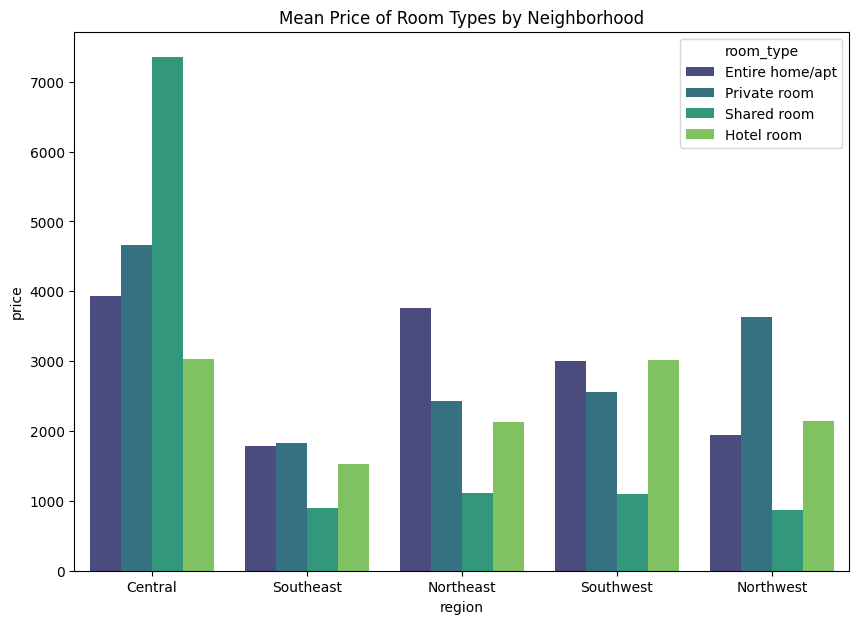

In [3983]:
# create graph to see the mean prices of each room_type in each zonal area - for cleaning purposes
plt.figure(figsize=(10, 7))
sns.barplot(x = "region", y = "price", data = df, hue = "room_type", estimator=np.mean, errorbar= None, palette="viridis")
plt.title("Mean Price of Room Types by Neighborhood")

Text(0.5, 1.0, 'Median Price of Room Types by Neighborhood')

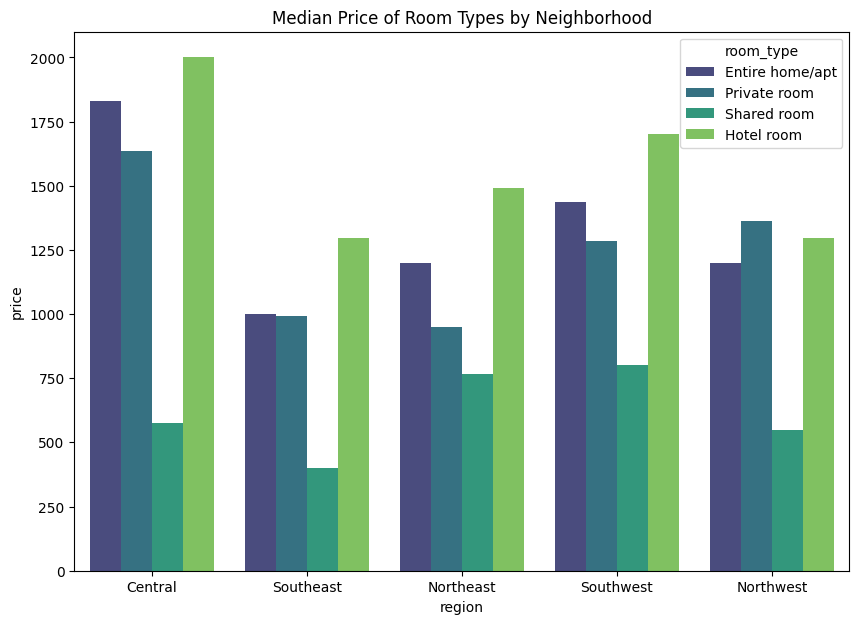

In [3984]:
# create graph to see the median prices of each room_type in each zonal area - for cleaning purposes
plt.figure(figsize=(10, 7))
sns.barplot(x = "region", y = "price", data = df, hue = "room_type", estimator=np.median, errorbar= None, palette="viridis")
plt.title("Median Price of Room Types by Neighborhood")

handle for when listing price == 0

In [3985]:
df[df["price"] == 0]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region
11103,44563108,Somerset Maison Asoke Bangkok,360620448,Somerset Maison Asoke,Vadhana,13.73815,100.5642,Hotel room,0,1,0,No Review,0.0,1,0,0,Central


In [3986]:
df = df.drop(11103)

In [3987]:
df[df["price"] == 0]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region


### Handling Outliers

In [3988]:
# outliers cleaned per region per room type
# create sub dataframes based on region
central = df[df["region"] == "Central"]
ne = df[df["region"] == "Northeast"]
nw = df[df["region"] == "Northwest"]
se = df[df["region"] == "Southeast"]
sw = df[df["region"] == "Southwest"]

## central

In [3989]:
# central["neighbourhood"].value_counts()

In [3990]:
# central["room_type"].value_counts()

Text(0.5, 1.0, 'Shared Room')

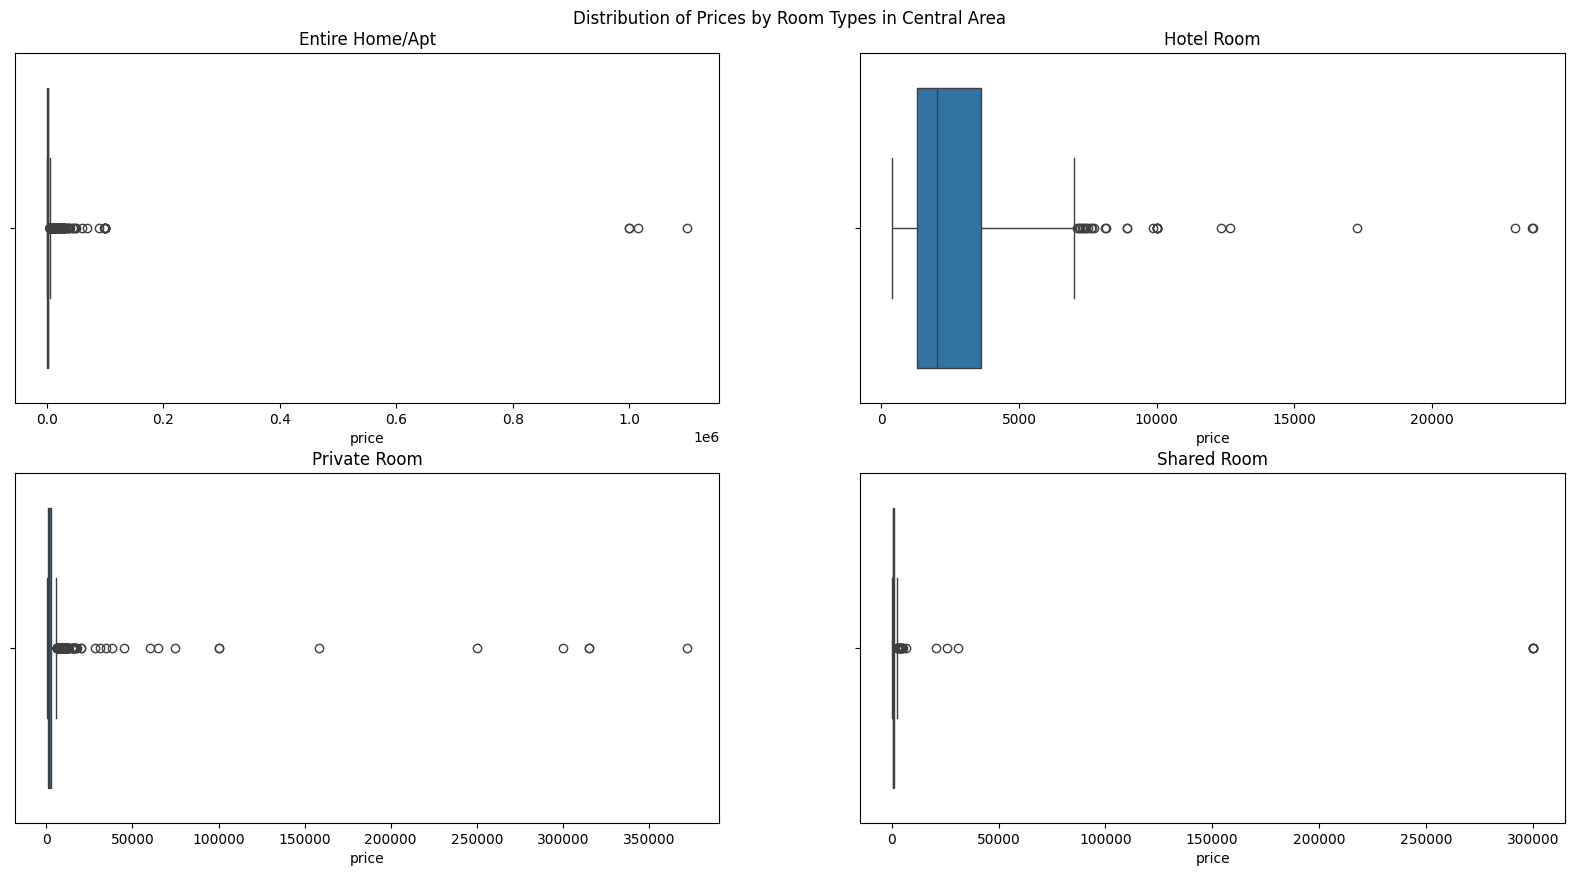

In [3991]:
# create histplot to see distribution of room_type price side by side in central area
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Central Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = central[central["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = central[central["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = central[central["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = central[central["room_type"] == "Shared room"])
plt.title("Shared Room")

- none are normally distributed
- there are outliers that need to be addressed

remove outliers from entire home/apt

In [3992]:
# central[central["room_type"] == "Entire home/apt"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 1000000 and up

In [3993]:
central = central.loc[~((central["room_type"] == "Entire home/apt") & (central["price"] >= 1000000))]

In [3994]:
# create function to calculate iqr and outliers
def price_outlier(df):
    Q1 = df["price"].quantile(0.25)
    Q3 = df["price"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_outliers = df[df["price"] < lower_bound]
    upper_outliers = df[df["price"] > upper_bound]

    return lower_outliers, upper_outliers, lower_bound, upper_bound

In [3995]:
len(price_outlier(central[central["room_type"] == "Entire home/apt"])[0])
len(price_outlier(central[central["room_type"] == "Entire home/apt"])[1])
value = price_outlier(central[central["room_type"] == "Entire home/apt"])[-1]

In [3996]:
central = central.loc[~((central["room_type"] == "Entire home/apt") & (central["price"] >= value))]

remove outliers from hotel room

In [3997]:
# central[central["room_type"] == "Hotel room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 15000 and up

In [3998]:
central = central.loc[~((central["room_type"] == "Hotel room") & (central["price"] >= 15000))]

In [3999]:
len(price_outlier(central[central["room_type"] == "Hotel room"])[0])
len(price_outlier(central[central["room_type"] == "Hotel room"])[1])
value = price_outlier(central[central["room_type"] == "Hotel room"])[-1]

In [4000]:
central = central.loc[~((central["room_type"] == "Hotel room") &  (central["price"] >= value))]

remove outliers from private room

In [4001]:
# central[central["room_type"] == "Private room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 100000 and up

In [4002]:
central = central.loc[~((central["room_type"] == "Private room") & (central["price"] >= 100000))]

In [4003]:
len(price_outlier(central[central["room_type"] == "Private room"])[0])
len(price_outlier(central[central["room_type"] == "Private room"])[1])
value = price_outlier(central[central["room_type"] == "Private room"])[-1]

In [4004]:
central = central.loc[~((central["room_type"] == "Private room") & (central["price"] >= value))]

remove outliers from shared room

In [4005]:
# central[central["room_type"] == "Shared room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 300000 and up

In [4006]:
central = central.loc[~((central["room_type"] == "Shared room") & (central["price"] >= 300000))]

In [4007]:
len(price_outlier(central[central["room_type"] == "Shared room"])[0])
len(price_outlier(central[central["room_type"] == "Shared room"])[1])
value = price_outlier(central[central["room_type"] == "Shared room"])[-1]

In [4008]:
central = central.loc[~((central["room_type"] == "Shared room") & (central["price"] >= value))]

Text(0.5, 1.0, 'Shared Room')

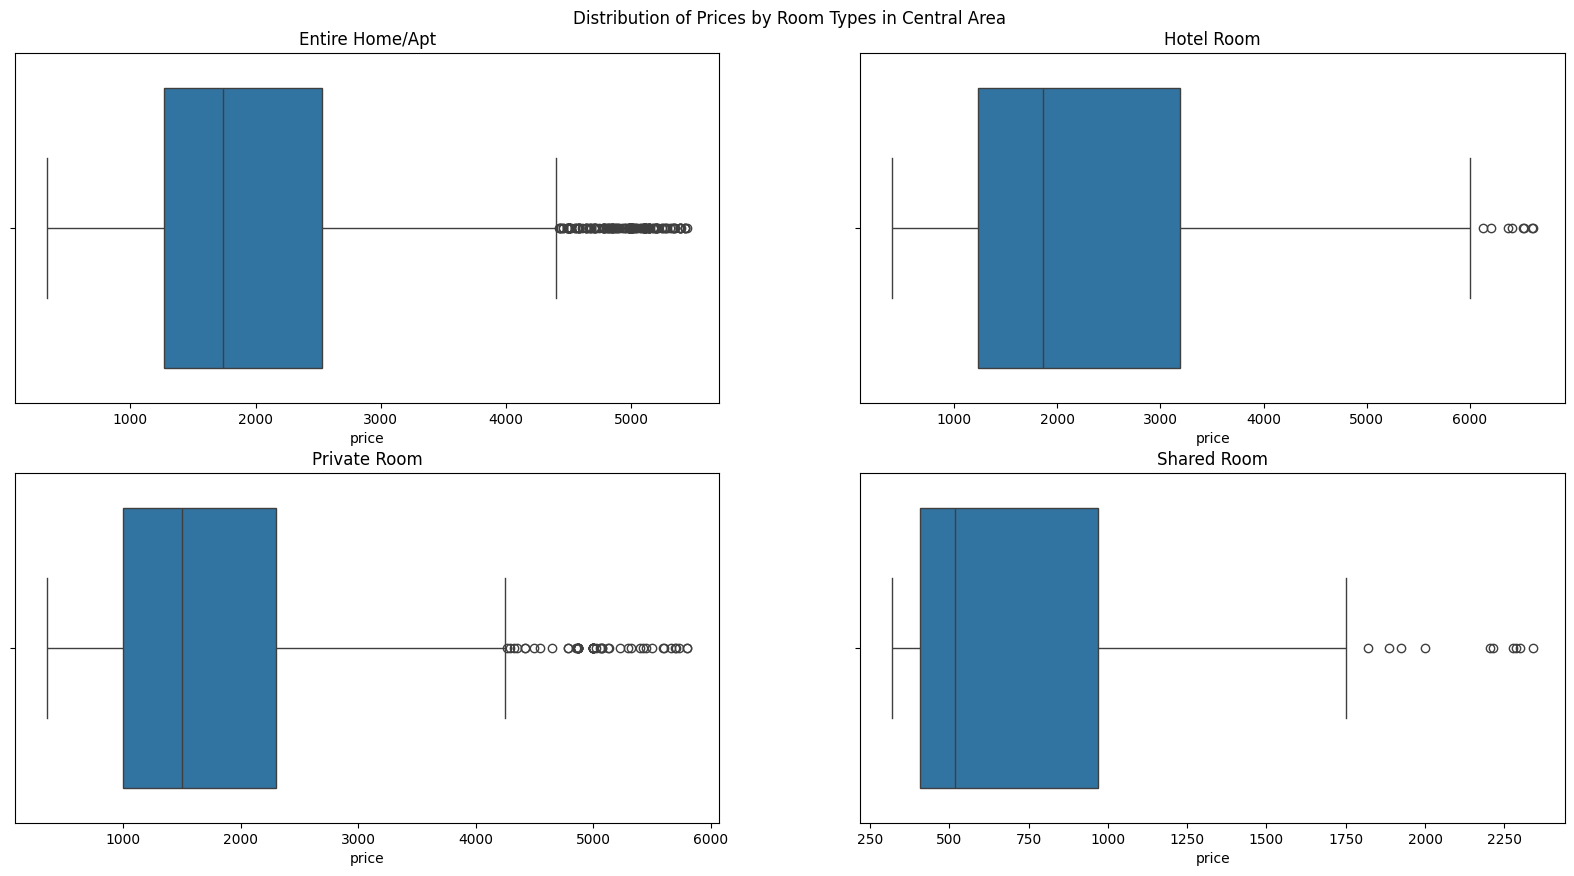

In [4009]:
# create histplot to see distribution of room_type price side by side in central area - after removing outliers
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Central Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = central[central["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = central[central["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = central[central["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = central[central["room_type"] == "Shared room"])
plt.title("Shared Room")

## Northeast

In [4010]:
# ne["neighbourhood"].value_counts()

In [4011]:
# ne["room_type"].value_counts()

Text(0.5, 1.0, 'Shared Room')

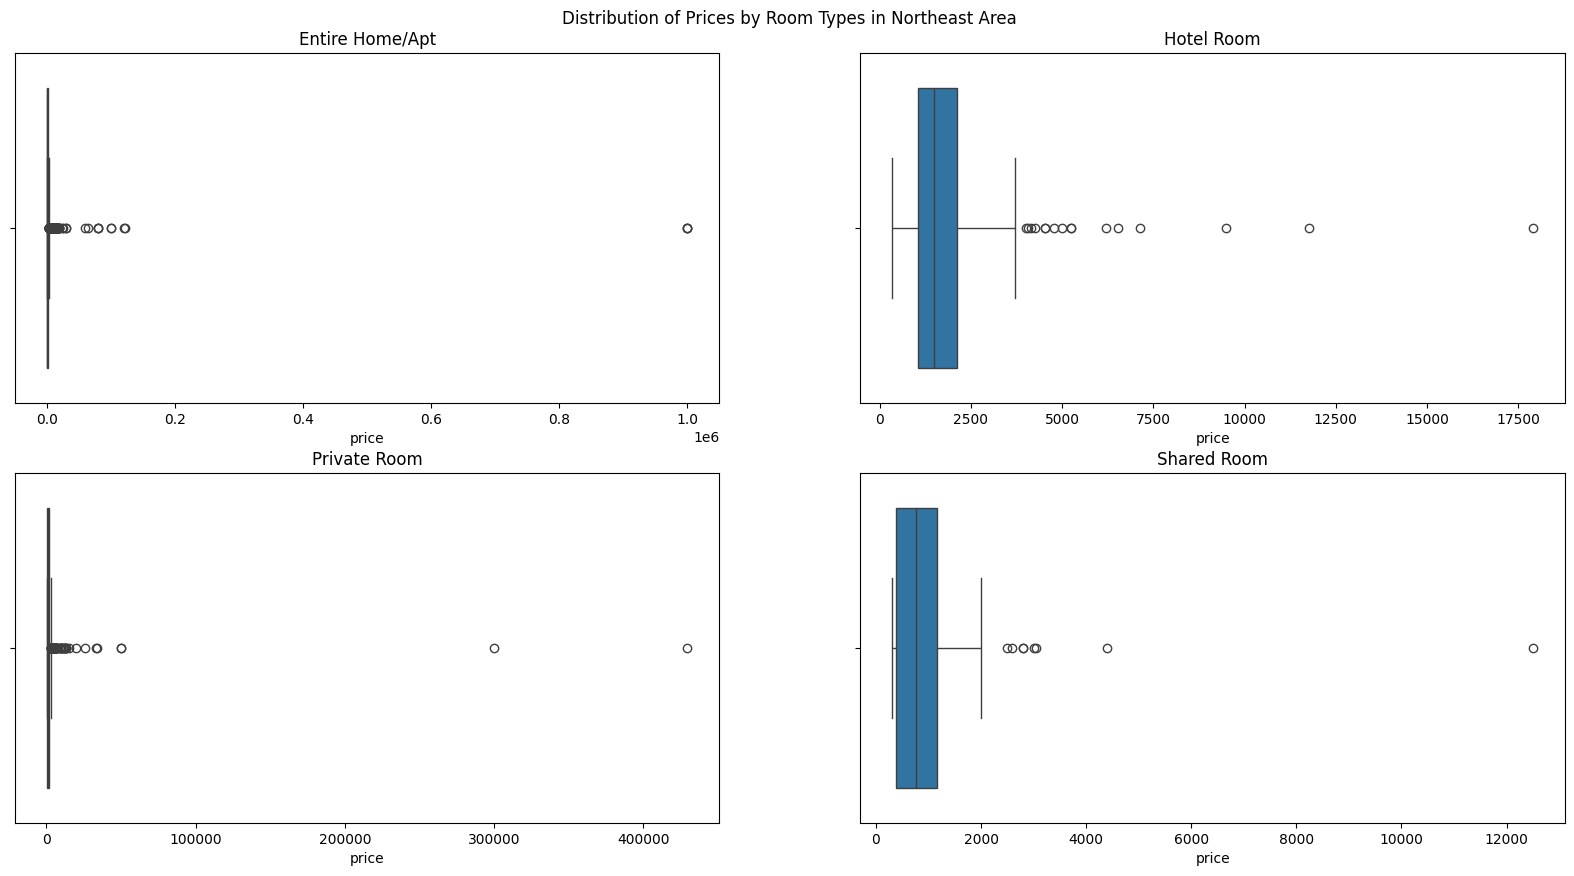

In [4012]:
# create histplot to see distribution of room_type price side by side in northeast area
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Northeast Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Shared room"])
plt.title("Shared Room")

- none are normally distributed
- need to handle outliers

remove outliers from entire home/apt

In [4013]:
# ne[ne["room_type"] == "Entire home/apt"].sort_values(by = "price", ascending=False).head(20)
# extreme outliers start from 60000 and up

In [4014]:
ne = ne.loc[~((ne["room_type"] == "Entire home/apt") & (ne["price"] >= 60000))]

In [4015]:
len(price_outlier(ne[ne["room_type"] == "Entire home/apt"])[0])
len(price_outlier(ne[ne["room_type"] == "Entire home/apt"])[1])
value = price_outlier(ne[ne["room_type"] == "Entire home/apt"])[-1]

In [4016]:
ne = ne.loc[~((ne["room_type"] == "Entire home/apt") & (ne["price"] >= value))]

remove outliers from hotel room

In [4017]:
# ne[ne["room_type"] == "Hotel room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 9500 and up

In [4018]:
ne = ne.loc[~((ne["room_type"] == "Hotel room") & (ne["price"] >= 9500))]

In [4019]:
len(price_outlier(ne[ne["room_type"] == "Hotel room"])[0])
len(price_outlier(ne[ne["room_type"] == "Hotel room"])[1])
value = price_outlier(ne[ne["room_type"] == "Hotel room"])[-1]

In [4020]:
ne = ne.loc[~((ne["room_type"] == "Hotel room") & (ne["price"] >= value))]

remove outliers from private room

In [4021]:
# ne[ne["room_type"] == "Private room"].sort_values(by = "price", ascending=False).head(15)
# extreme outliers start from 300000 and up

In [4022]:
ne = ne.loc[~((ne["room_type"] == "Private room") & (ne["price"] >= 300000))]

In [4023]:
len(price_outlier(ne[ne["room_type"] == "Private room"])[0])
len(price_outlier(ne[ne["room_type"] == "Private room"])[1])
value = price_outlier(ne[ne["room_type"] == "Private room"])[-1]

In [4024]:
ne = ne.loc[~((ne["room_type"] == "Private room") & (ne["price"] >= value))]

remove outliers from shared room

In [4025]:
# ne[ne["room_type"] == "Shared room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 4400 and up

In [4026]:
ne = ne.loc[~((ne["room_type"] == "Shared room") & (ne["price"] >= 4400))]

In [4027]:
len(price_outlier(ne[ne["room_type"] == "Shared room"])[0])
len(price_outlier(ne[ne["room_type"] == "Shared room"])[1])
value = price_outlier(ne[ne["room_type"] == "Shared room"])[-1]

In [4028]:
ne = ne.loc[~((ne["room_type"] == "Shared room") & (ne["price"] >= value))]

Text(0.5, 1.0, 'Shared Room')

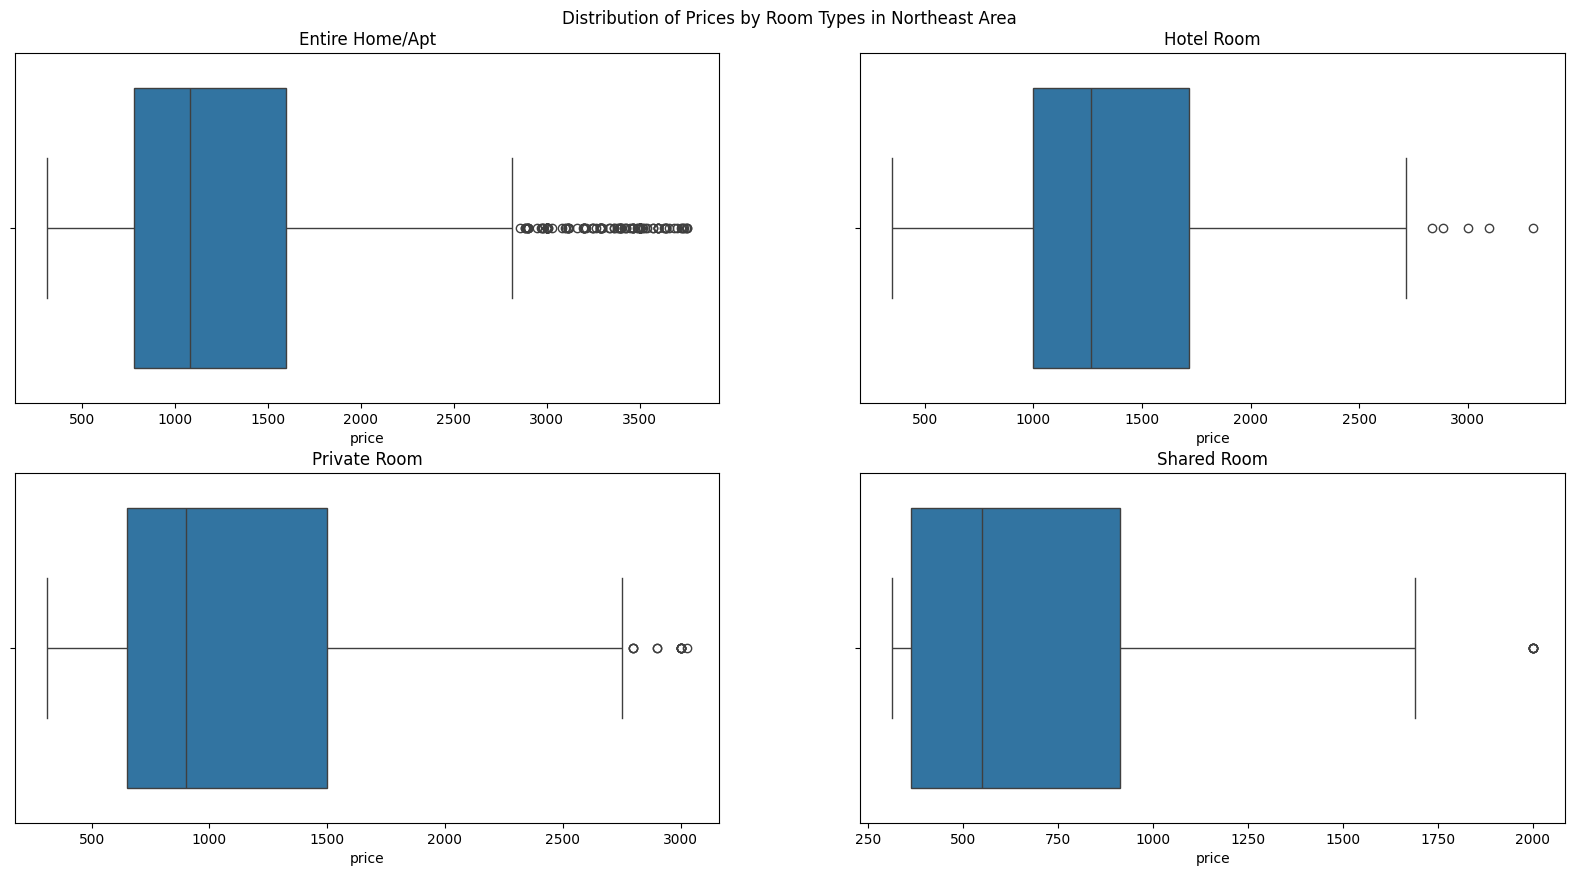

In [4029]:
# create histplot to see distribution of room_type price side by side in northeast area - after removing outliers
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Northeast Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = ne[ne["room_type"] == "Shared room"])
plt.title("Shared Room")

## Southeast

In [4030]:
# se["neighbourhood"].value_counts()

In [4031]:
# se["room_type"].value_counts()

Text(0.5, 1.0, 'Shared Room')

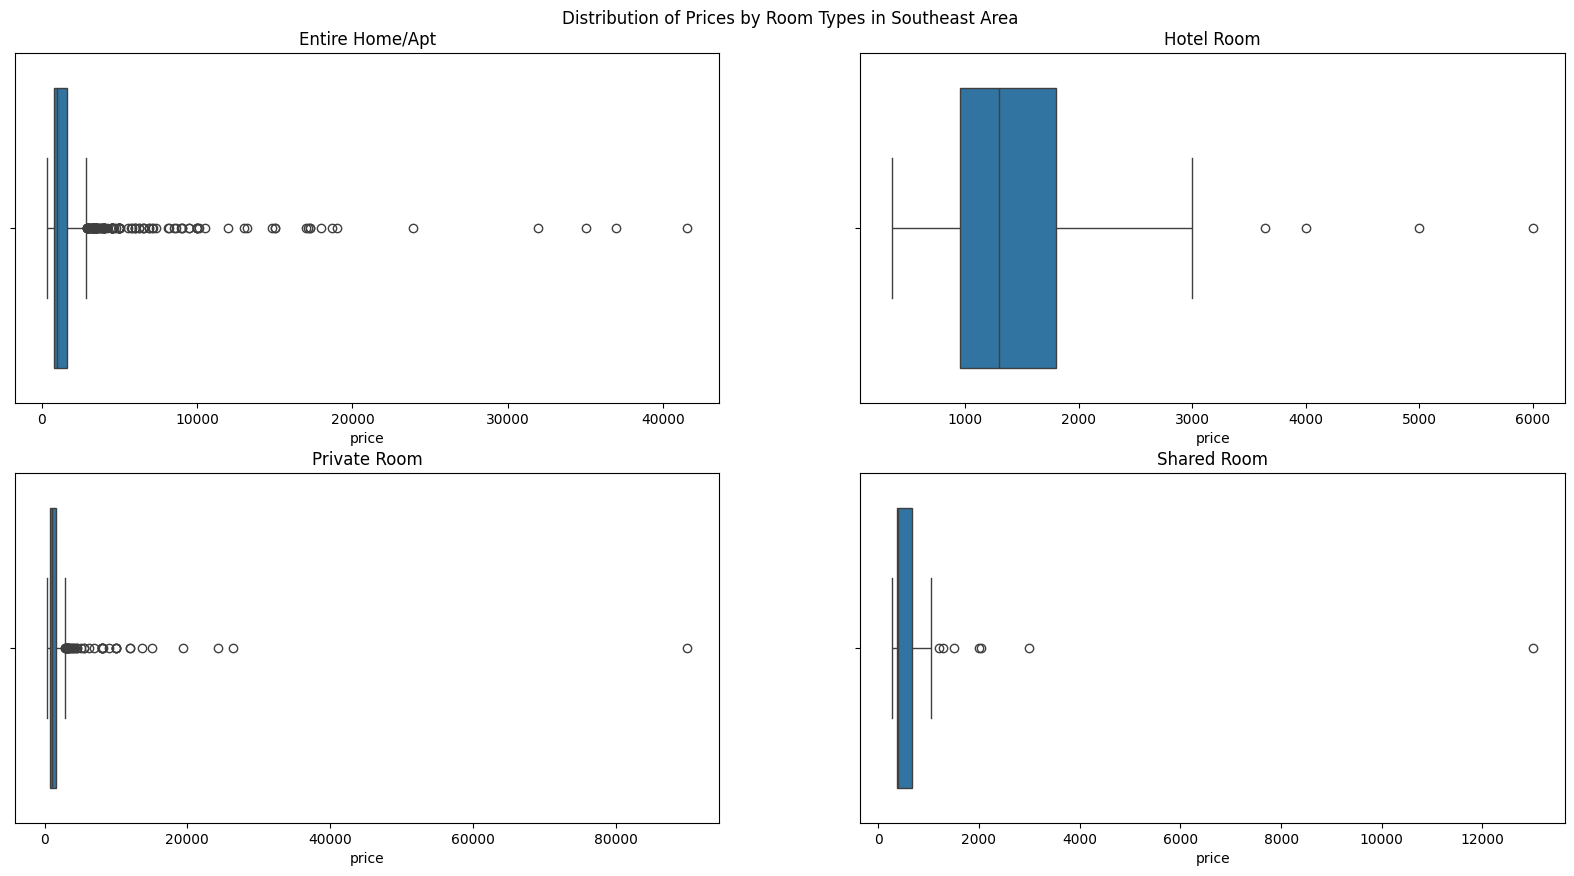

In [4032]:
# create histplot to see distribution of room_type price side by side in southeast area
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Southeast Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = se[se["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = se[se["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = se[se["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = se[se["room_type"] == "Shared room"])
plt.title("Shared Room")

remove outliers from entire home/apt

In [4033]:
se[se["room_type"] == "Entire home/apt"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 23900 and up

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region
5061,24882757,Detached House for rent in bangkok \n\n$1200/m...,188113892,Preeyawadee,Pra Wet,13.658080,100.693950,Entire home/apt,41557,1,0,No Review,0.00,1,365,0,Southeast
8812,38003654,[Staycation]Near Rot Fai Train Night Market Condo,263356033,Elements,Pra Wet,13.696550,100.646920,Entire home/apt,36950,1,8,2020-03-02,0.20,6,365,0,Southeast
1200,8801560,"30th floor, 10 min to BTS, Seaview",4517723,Kannicha,Bang Na,13.664170,100.649550,Entire home/apt,35000,998,20,2022-10-30,0.26,7,365,5,Southeast
13878,709796043409681676,"4 Br Villa with Private Plunge Pool, On Nut bts",477497744,Vichak,Suanluang,13.709420,100.611170,Entire home/apt,31910,1,0,No Review,0.00,6,347,0,Southeast
13062,650615715315613350,Pool Villa 107A,351309638,Smirah,Bang Na,13.662210,100.602340,Entire home/apt,23900,1,4,2022-12-18,0.77,5,360,4,Southeast
3963,20792684,ให้เช่า ทาวน์โฮม 4 ชั้น สุขุมวิท 101/1 ใกล้ BTS,147034553,ปฏิคม,Bang Na,13.681760,100.614310,Entire home/apt,19000,1,0,No Review,0.00,1,365,0,Southeast
13063,650615903512188048,Pool Villa 103,351309638,Smirah,Bang Na,13.678675,100.609256,Entire home/apt,18714,1,6,2022-12-07,0.96,5,340,6,Southeast
5171,25548273,"2Houses+10Bed+10Bath, Daily Cleaning, Free Pic...",6906718,Anne Araya,Phra Khanong,13.698800,100.606990,Entire home/apt,18000,1,3,2020-01-28,0.06,25,302,0,Southeast
11805,50802053,Private Plunge Pool Villa 4 BR for Dinner Party!,240603715,Sasikarn,Suanluang,13.712410,100.635390,Entire home/apt,17286,1,1,2022-04-17,0.12,31,159,1,Southeast
12725,608356358644561446,"Shan : Private Plunge Pool Villa 4 BR , Free WIFI",240603715,Sasikarn,Suanluang,13.708510,100.613270,Entire home/apt,17286,1,0,No Review,0.00,31,348,0,Southeast


In [4034]:
se = se.loc[~((se["room_type"] == "Entire home/apt") & (se["price"] >= 23900))]

In [4035]:
len(price_outlier(se[se["room_type"] == "Entire home/apt"])[0])
len(price_outlier(se[se["room_type"] == "Entire home/apt"])[1])
value = price_outlier(se[se["room_type"] == "Entire home/apt"])[-1]

In [4036]:
se = se.loc[~((se["room_type"] == "Entire home/apt") & (se["price"] >= value))]

remove outliers from hotel room

In [4037]:
# se[se["room_type"] == "Hotel room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 5000 and up

In [4038]:
se = se.loc[~((se["room_type"] == "Hotel room") & (se["price"] >= 5000))]

In [4039]:
len(price_outlier(se[se["room_type"] == "Hotel room"])[0])
len(price_outlier(se[se["room_type"] == "Hotel room"])[1])
value = price_outlier(se[se["room_type"] == "Hotel room"])[-1]

In [4040]:
se = se.loc[~((se["room_type"] == "Hotel room") & (se["price"] >= value))]

remove outliers from private room

In [4041]:
# se[se["room_type"] == "Private room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 80000 and up

In [4042]:
se = se.loc[~((se["room_type"] == "Private room") & (se["price"] >= 80000))]

In [4043]:
len(price_outlier(se[se["room_type"] == "Private room"])[0])
len(price_outlier(se[se["room_type"] == "Private room"])[1])
value = price_outlier(se[se["room_type"] == "Private room"])[-1]

In [4044]:
se = se.loc[~((se["room_type"] == "Private room") & (se["price"] >= value))]

remove outliers from shared room

In [4045]:
# se[se["room_type"] == "Shared room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 13000 and up

In [4046]:
se = se.loc[~((se["room_type"] == "Shared room") & (se["price"] >= 13000))]

In [4047]:
len(price_outlier(se[se["room_type"] == "Shared room"])[0])
len(price_outlier(se[se["room_type"] == "Shared room"])[1])
value = price_outlier(se[se["room_type"] == "Shared room"])[-1]

In [4048]:
se = se.loc[~((se["room_type"] == "Shared room") & (se["price"] >= value))]

Text(0.5, 1.0, 'Shared Room')

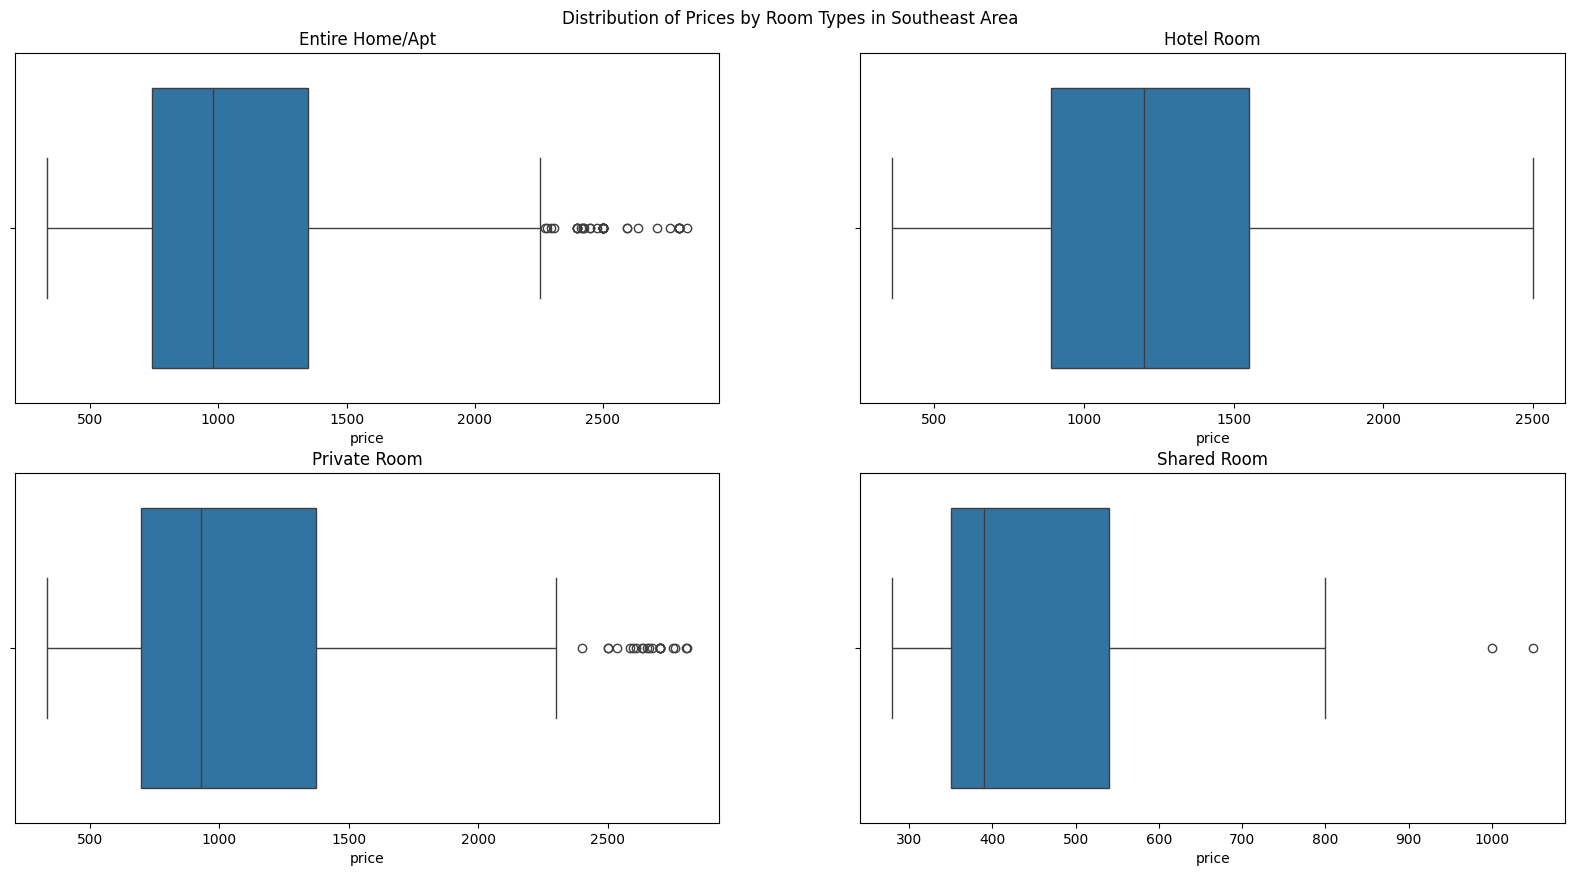

In [4049]:
# create histplot to see distribution of room_type price side by side in southeast area - after removing outliers
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Southeast Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = se[se["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = se[se["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = se[se["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = se[se["room_type"] == "Shared room"])
plt.title("Shared Room")

## Northwest

In [4050]:
# nw["neighbourhood"].value_counts()

In [4051]:
# nw["room_type"].value_counts()

Text(0.5, 1.0, 'Shared Room')

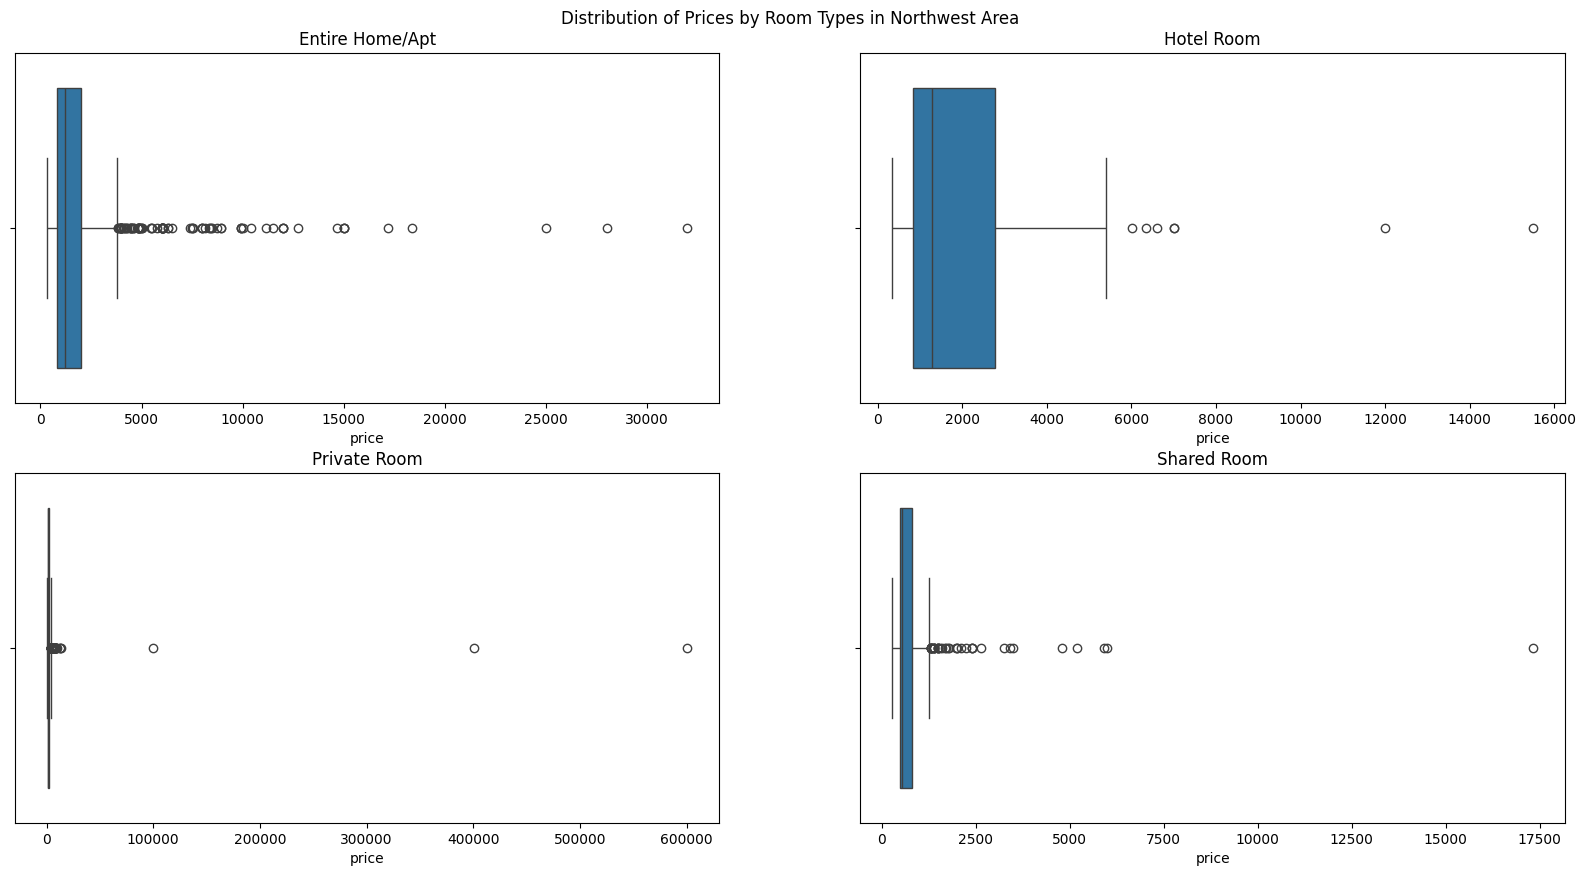

In [4052]:
# create histplot to see distribution of room_type price side by side in northwest area
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Northwest Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Shared room"])
plt.title("Shared Room")

- not normally distributed
- need to handle outliers

remove outliers from entire home/apt

In [4053]:
# nw[nw["room_type"] == "Entire home/apt"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 25000 and up

In [4054]:
nw = nw.loc[~((nw["room_type"] == "Entire home/apt") & (nw["price"] >= 25000))]

In [4055]:
len(price_outlier(nw[nw["room_type"] == "Entire home/apt"])[0])
len(price_outlier(nw[nw["room_type"] == "Entire home/apt"])[1])
value = price_outlier(nw[nw["room_type"] == "Entire home/apt"])[-1]

In [4056]:
nw = nw.loc[~((nw["room_type"] == "Entire home/apt") & (nw["price"] >= value))]

remove outlier from hotel room

In [4057]:
# nw[nw["room_type"] == "Hotel room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 12000 and up

In [4058]:
nw = nw.loc[~((nw["room_type"] == "Hotel room") & (nw["price"] >= 12000))]

In [4059]:
len(price_outlier(nw[nw["room_type"] == "Hotel room"])[0])
len(price_outlier(nw[nw["room_type"] == "Hotel room"])[1])
value = price_outlier(nw[nw["room_type"] == "Hotel room"])[-1]

In [4060]:
nw = nw.loc[~((nw["room_type"] == "Hotel room") & (nw["price"] >= value))]

remove outliers from private room

In [4061]:
# nw[nw["room_type"] == "Private room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 100000 and up

In [4062]:
nw = nw.loc[~((nw["room_type"] == "Private room") & (nw["price"] >= 100000))]

In [4063]:
len(price_outlier(nw[nw["room_type"] == "Private room"])[0])
len(price_outlier(nw[nw["room_type"] == "Private room"])[1])
value = price_outlier(nw[nw["room_type"] == "Private room"])[-1]

In [4064]:
nw = nw.loc[~((nw["room_type"] == "Private room") & (nw["price"] >= value))]

remove outliers from shared room

In [4065]:
# nw[nw["room_type"] == "Shared room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 5195 and up

In [4066]:
nw = nw.loc[~((nw["room_type"] == "Shared room") & (nw["price"] >= 5195))]

In [4067]:
len(price_outlier(nw[nw["room_type"] == "Shared room"])[0])
len(price_outlier(nw[nw["room_type"] == "Shared room"])[1])
value = price_outlier(nw[nw["room_type"] == "Shared room"])[-1]

In [4068]:
nw = nw.loc[~((nw["room_type"] == "Shared room") & (nw["price"] >= value))]

Text(0.5, 1.0, 'Shared Room')

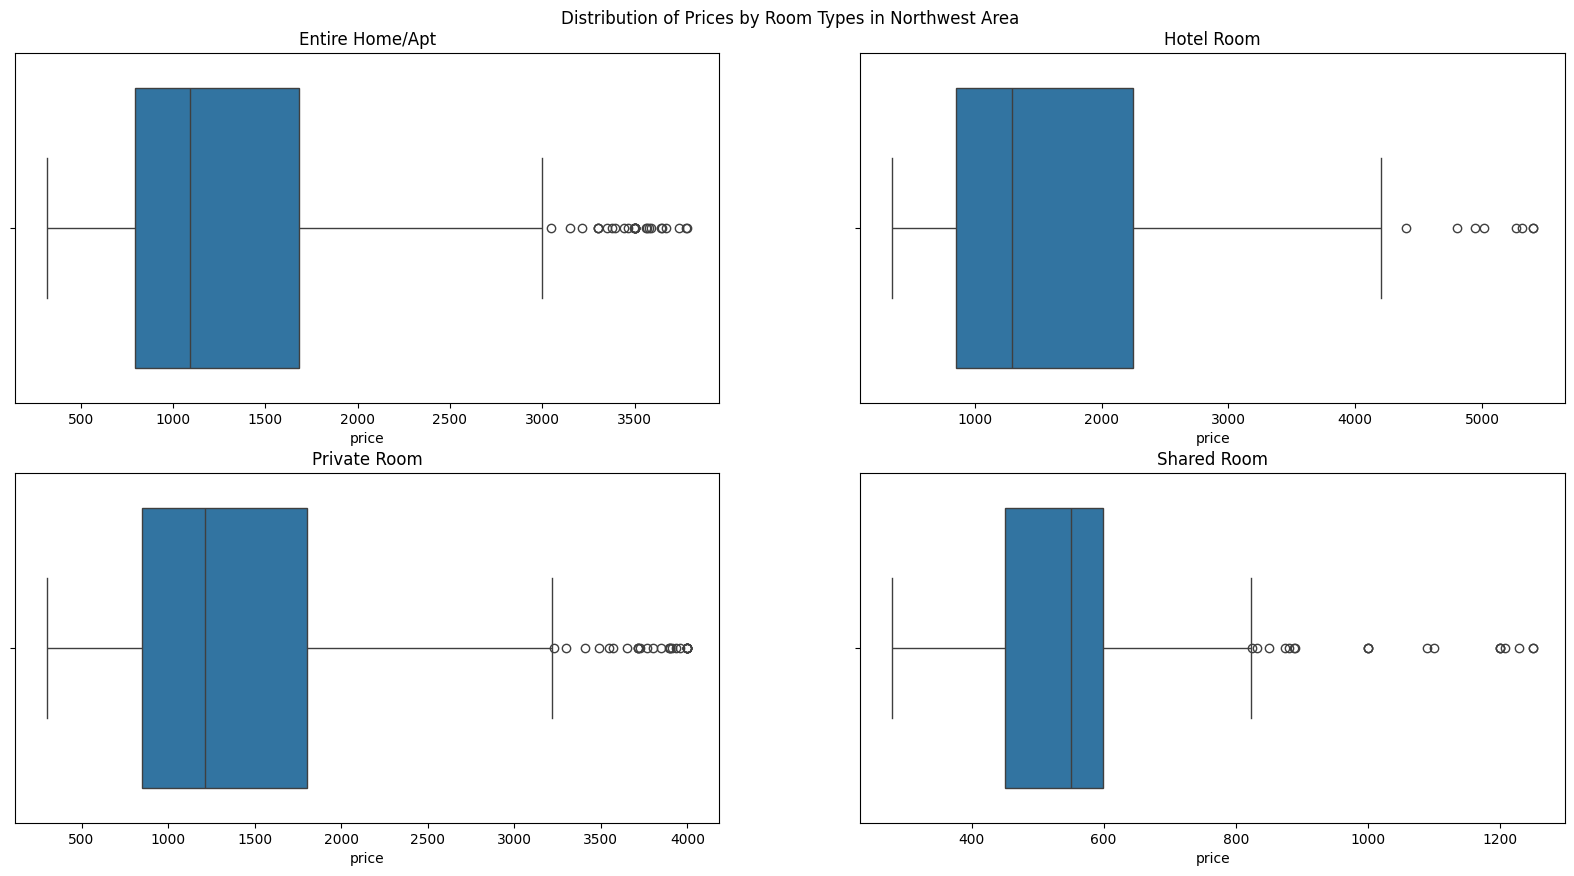

In [4069]:
# create histplot to see distribution of room_type price side by side in northwest area - after removing outliers
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Northwest Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = nw[nw["room_type"] == "Shared room"])
plt.title("Shared Room")

## Southwest

In [4070]:
# sw["neighbourhood"].value_counts()

In [4071]:
# sw["room_type"].value_counts()

Text(0.5, 1.0, 'Shared Room')

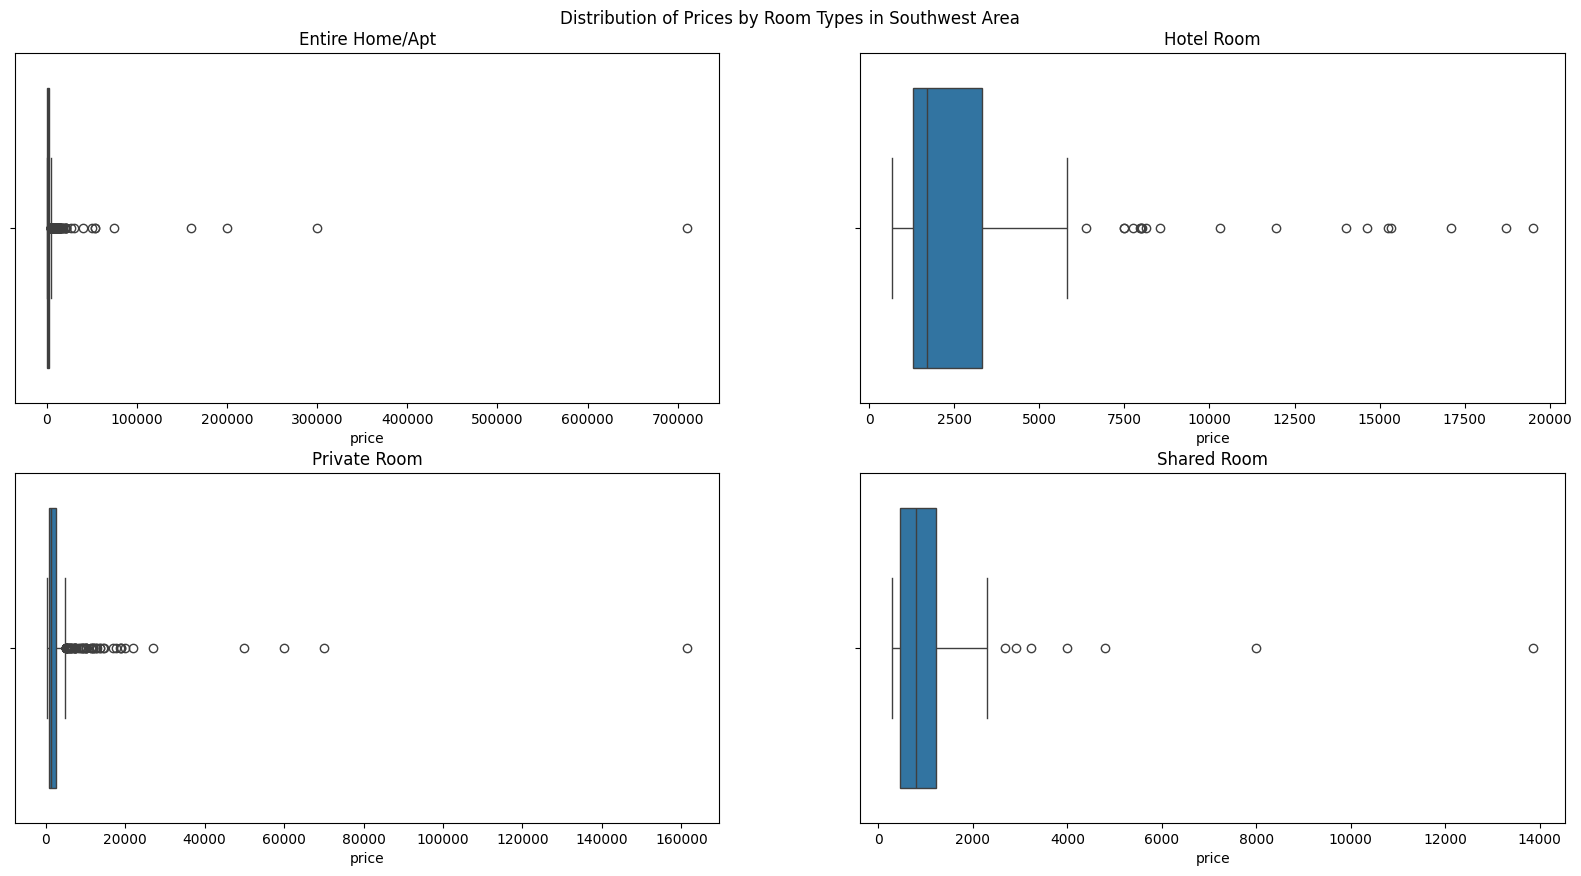

In [4072]:
# create histplot to see distribution of room_type price side by side in northwest area
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Southwest Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Shared room"])
plt.title("Shared Room")

remove outliers from entire home/apt

In [4073]:
# sw[sw["room_type"] == "Entire home/apt"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 160000 and up

In [4074]:
sw = sw.loc[~((sw["room_type"] == "Entire home/apt") & (sw["price"] >= 160000))]

In [4075]:
len(price_outlier(sw[sw["room_type"] == "Entire home/apt"])[0])
len(price_outlier(sw[sw["room_type"] == "Entire home/apt"])[1])
value = price_outlier(sw[sw["room_type"] == "Entire home/apt"])[-1]

In [4076]:
sw = sw.loc[~((sw["room_type"] == "Entire home/apt") & (sw["price"] >= value))]

remove outliers from hotel room

In [4077]:
# sw[sw["room_type"] == "Hotel room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 10313 and up

In [4078]:
sw = sw.loc[~((sw["room_type"] == "Hotel room") & (sw["price"] >= 160000))]

In [4079]:
len(price_outlier(sw[sw["room_type"] == "Hotel room"])[0])
len(price_outlier(sw[sw["room_type"] == "Hotel room"])[1])
value = price_outlier(sw[sw["room_type"] == "Hotel room"])[-1]

In [4080]:
sw = sw.loc[~((sw["room_type"] == "Hotel room") & (sw["price"] >= value))]

remove outliers from private room

In [4081]:
# sw[sw["room_type"] == "Private room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 50000 and up

In [4082]:
sw = sw.loc[~((sw["room_type"] == "Private room") & (sw["price"] >= 50000))]

In [4083]:
len(price_outlier(sw[sw["room_type"] == "Private room"])[0])
len(price_outlier(sw[sw["room_type"] == "Private room"])[1])
value = price_outlier(sw[sw["room_type"] == "Private room"])[-1]

In [4084]:
sw = sw.loc[~((sw["room_type"] == "Private room") & (sw["price"] >= value))]

remove outliers from shared room

In [4085]:
# sw[sw["room_type"] == "Shared room"].sort_values(by = "price", ascending=False).head(10)
# extreme outliers start from 8000 and up

In [4086]:
sw = sw.loc[~((sw["room_type"] == "Shared room") & (sw["price"] >= 50000))]

In [4087]:
len(price_outlier(sw[sw["room_type"] == "Shared room"])[0])
len(price_outlier(sw[sw["room_type"] == "Shared room"])[1])
value = price_outlier(sw[sw["room_type"] == "Shared room"])[-1]

In [4088]:
sw = sw.loc[~((sw["room_type"] == "Shared room") & (sw["price"] >= value))]

Text(0.5, 1.0, 'Shared Room')

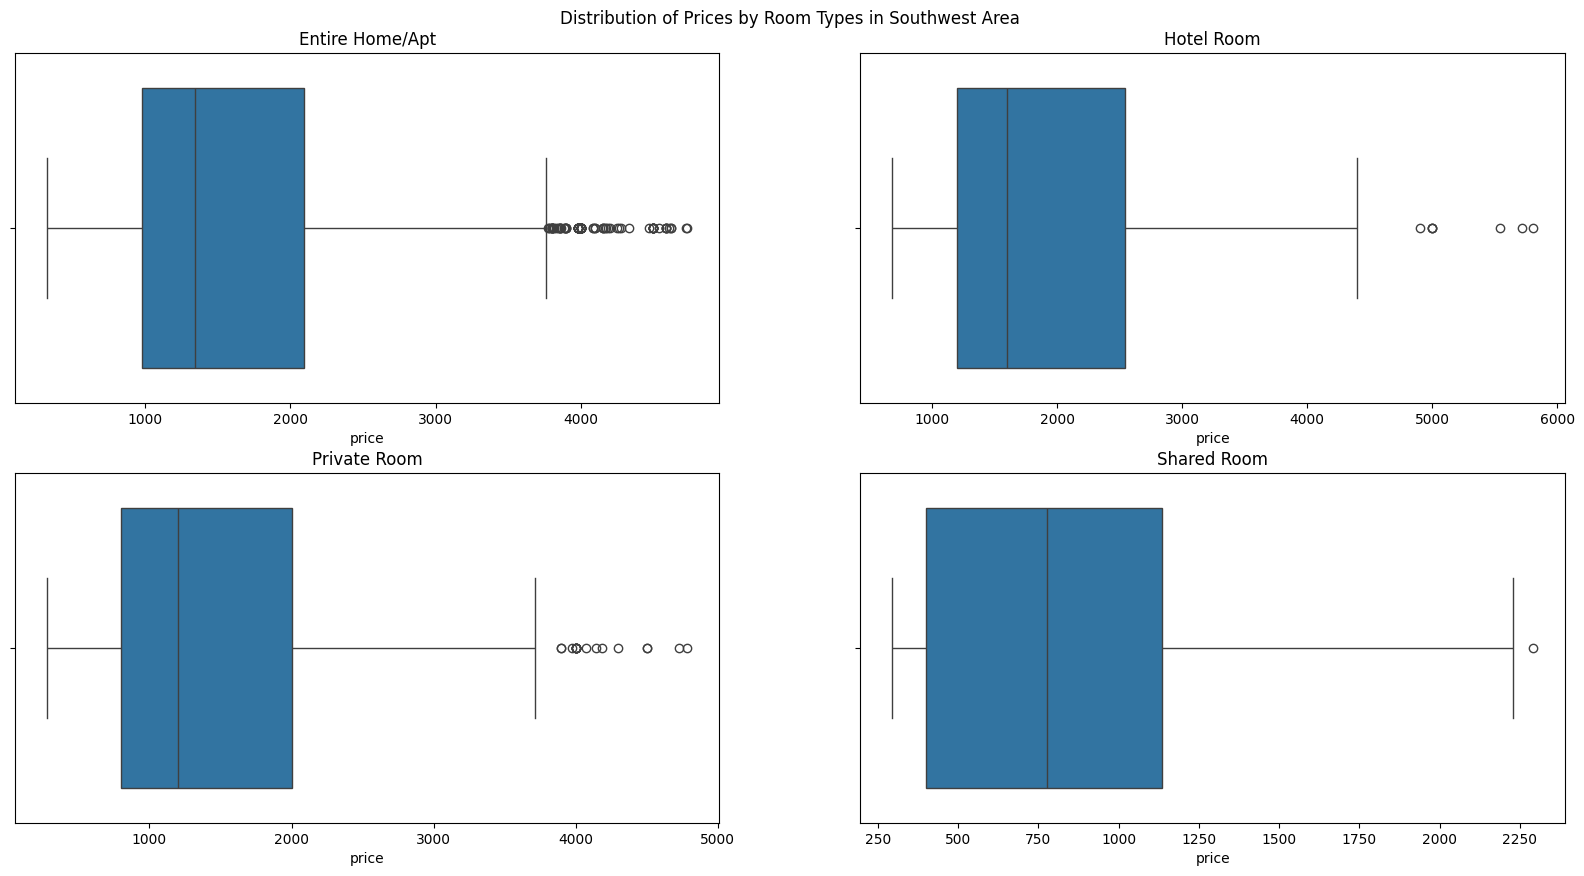

In [4089]:
# create histplot to see distribution of room_type price side by side in northwest area - after removing outliers
plt.figure(figsize=(20, 10))
plt.title("Distribution of Prices by Room Types in Southwest Area\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Entire home/apt"])
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Hotel room"])
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Private room"])
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.boxplot(x = "price", data = sw[sw["room_type"] == "Shared room"])
plt.title("Shared Room")

In [4090]:
df2 = pd.concat([central, nw, sw, ne, se])

In [4091]:
# df2.head()

In [4092]:
df2 = df2[["id", "region", "neighbourhood", "room_type", "price", "number_of_reviews", "availability_365"]]

In [4093]:
# booking_activity = 365 - availability 365 (the number of days the listing is booked 365 days in the future)
df2.loc[:, "booking_activity"] = 365 - df2["availability_365"]

In [4094]:
df2 = df2.drop(columns = ["id", "availability_365"])

# EDA

In [4095]:
df2.head()

,region,neighbourhood,room_type,price,number_of_reviews,booking_activity
0,Central,Ratchathewi,Entire home/apt,1905,65,12
14,Central,Khlong Toei,Entire home/apt,1400,0,0
16,Central,Khlong Toei,Entire home/apt,1577,78,35
19,Central,Vadhana,Entire home/apt,5034,287,16
22,Central,Vadhana,Private room,3775,3,1


In [4096]:
corr_mtx = df2.corr(numeric_only=True)

print(corr_mtx)

                      price  number_of_reviews  booking_activity
price              1.000000           0.019931          0.017853
number_of_reviews  0.019931           1.000000          0.078932
booking_activity   0.017853           0.078932          1.000000


<Axes: >

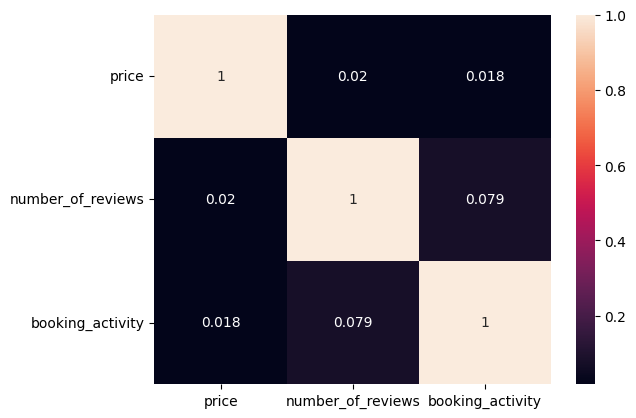

In [4097]:
# overall correlation heatmap
sns.heatmap(corr_mtx, annot= True)

In [4098]:
# correlation heatmap based on room type in all regions
# create all the dataframes
eha_corr = df2[df2["room_type"] == "Entire home/apt"].corr(numeric_only=True)
hr_corr = df2[df2["room_type"] == "Hotel room"].corr(numeric_only=True)
pr_corr = df2[df2["room_type"] == "Private room"].corr(numeric_only=True)
sr_corr = df2[df2["room_type"] == "Shared room"].corr(numeric_only=True)

Text(0.5, 1.0, 'Correlation of Shared Room')

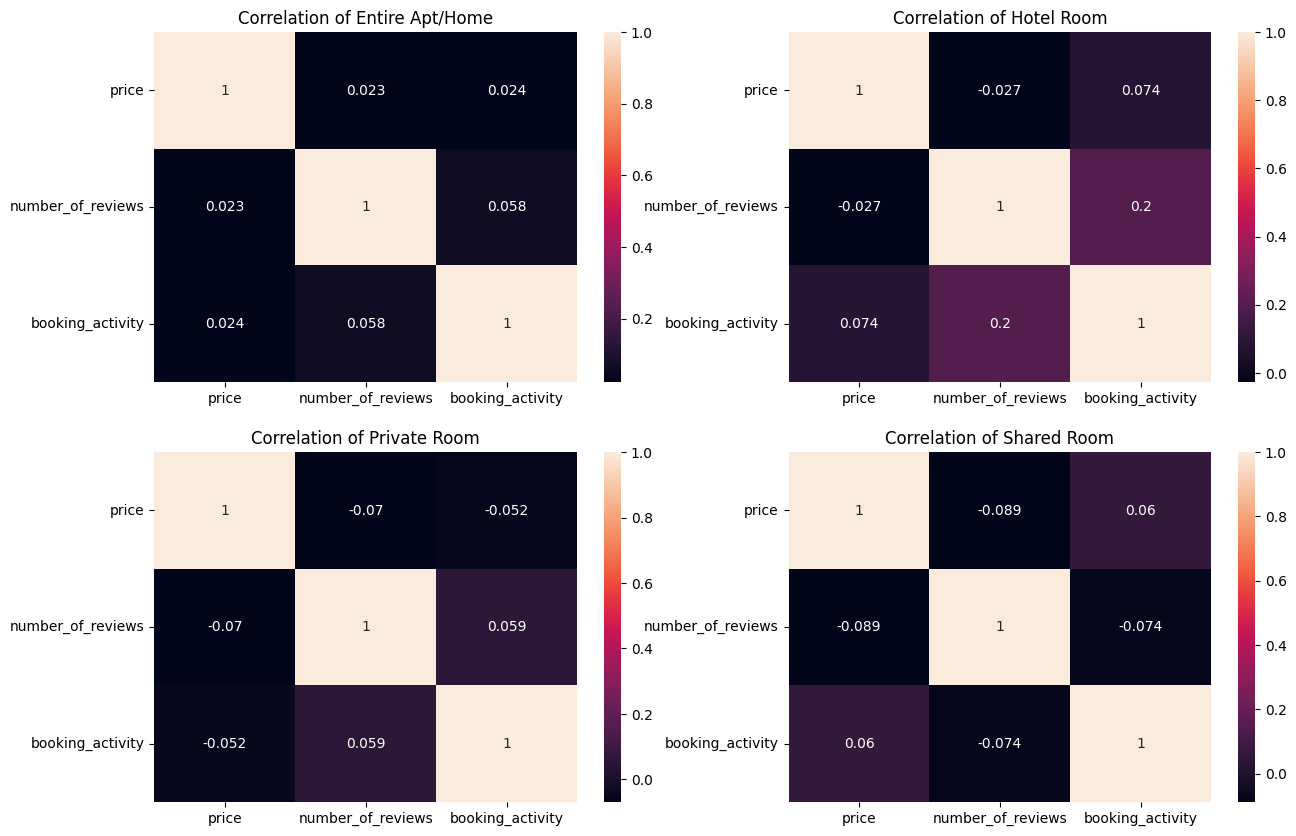

In [4099]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.heatmap(eha_corr, annot= True)
plt.title("Correlation of Entire Apt/Home")

plt.subplot(2, 2, 2)
sns.heatmap(hr_corr, annot= True)
plt.title("Correlation of Hotel Room")

plt.subplot(2, 2, 3)
sns.heatmap(pr_corr, annot= True)
plt.title("Correlation of Private Room")

plt.subplot(2, 2, 4)
sns.heatmap(sr_corr, annot= True)
plt.title("Correlation of Shared Room")

### Distribution of Number of Reviews

Text(0.5, 1.0, 'Distribution of Number of Reviews in Each Region')

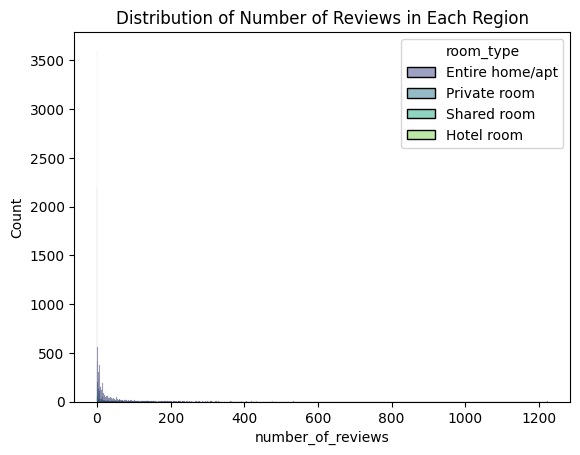

In [4100]:
sns.histplot(x = "number_of_reviews", data = df2, hue = "room_type", palette="viridis")
plt.title("Distribution of Number of Reviews in Each Region")

In [4101]:
# log number of reviews
df2.loc[:, "log_reviews"] = np.log1p(df2["number_of_reviews"])

In [4102]:
df2.head()

,region,neighbourhood,room_type,price,number_of_reviews,booking_activity,log_reviews
0,Central,Ratchathewi,Entire home/apt,1905,65,12,4.189655
14,Central,Khlong Toei,Entire home/apt,1400,0,0,0.000000
16,Central,Khlong Toei,Entire home/apt,1577,78,35,4.369448
19,Central,Vadhana,Entire home/apt,5034,287,16,5.662960
22,Central,Vadhana,Private room,3775,3,1,1.386294


Text(0.5, 1.0, 'Logged Distribution of Number of Reviews in Each Region')

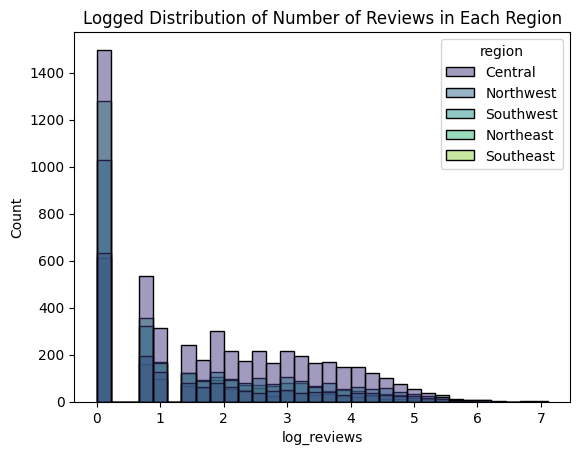

In [4103]:
sns.histplot(x = "log_reviews", data = df2, hue = "region", palette="viridis")
plt.title("Logged Distribution of Number of Reviews in Each Region")

In [4104]:
# ordinal ranking to logged number of reviews
q1 = df2["log_reviews"].quantile(0.33)
q2 = df2["log_reviews"].quantile(0.66)

bins = [df2["log_reviews"].min(), q1 + 0.01, q2, df2["log_reviews"].max()]
labels = [1, 2, 3]

df2 = df2.copy()  
df2.loc[:, "ord_log_reviews"] = pd.cut(df2["log_reviews"], bins=bins, labels=labels, include_lowest=True)

In [4105]:
# change data type
df2["ord_log_reviews"] = df2["ord_log_reviews"].astype(int)

(np.float64(-1.0999991106217146),
 np.float64(1.099999957648653),
 np.float64(-1.0999995963392553),
 np.float64(1.0999995053277365))

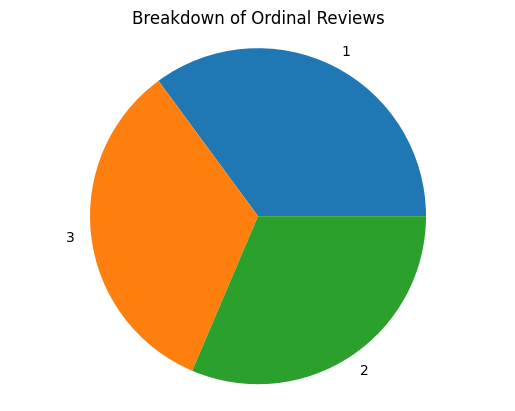

In [4106]:
counts = df2["ord_log_reviews"].value_counts()
plt.pie(counts, labels=counts.index)
plt.title("Breakdown of Ordinal Reviews")
plt.axis('equal')

### Distribution of Booking Activity

Text(0.5, 1.0, 'Distribution of Booking Activity in Each Region')

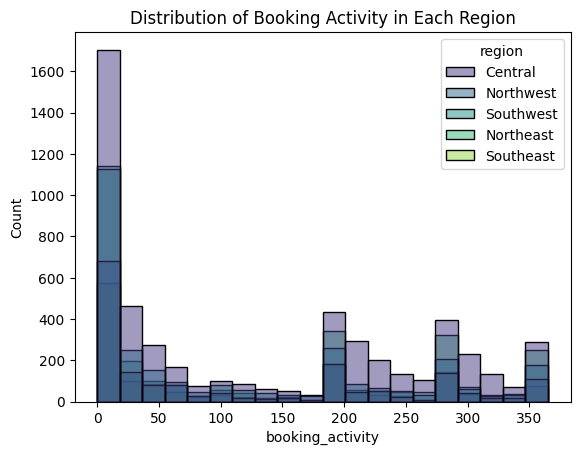

In [4107]:
sns.histplot(x = "booking_activity", data = df2, hue = "region", palette="viridis")
plt.title("Distribution of Booking Activity in Each Region")

In [4108]:
# ordinal ranking to booking_activity
q1 = df2["booking_activity"].quantile(0.33)
q2 = df2["booking_activity"].quantile(0.66)

bins = [df2["booking_activity"].min(), q1 + 0.01, q2, df2["booking_activity"].max()]
labels = [1, 2, 3]

df2 = df2.copy()  
df2.loc[:, "ord_booking"] = pd.cut(df2["booking_activity"], bins=bins, labels=labels, include_lowest=True)

In [4109]:
# change data type
df2["ord_booking"] = df2["ord_booking"].astype(int)

In [4110]:
df2.head()

,region,neighbourhood,room_type,price,number_of_reviews,booking_activity,log_reviews,ord_log_reviews,ord_booking
0,Central,Ratchathewi,Entire home/apt,1905,65,12,4.189655,3,1
14,Central,Khlong Toei,Entire home/apt,1400,0,0,0.000000,1,1
16,Central,Khlong Toei,Entire home/apt,1577,78,35,4.369448,3,2
19,Central,Vadhana,Entire home/apt,5034,287,16,5.662960,3,2
22,Central,Vadhana,Private room,3775,3,1,1.386294,2,1


(np.float64(-1.0999999981241573),
 np.float64(1.0999999999106742),
 np.float64(-1.0999999821946032),
 np.float64(1.0999999903884905))

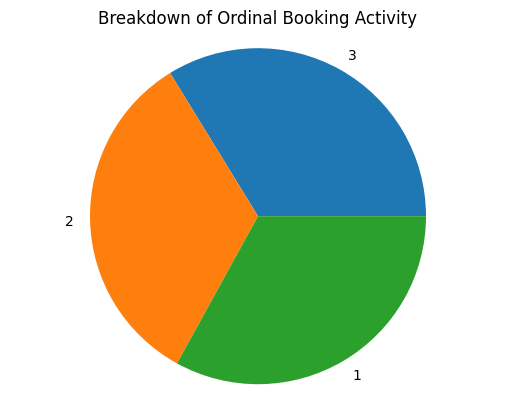

In [4111]:
counts = df2["ord_booking"].value_counts()
plt.pie(counts, labels=counts.index)
plt.title("Breakdown of Ordinal Booking Activity")
plt.axis('equal')

### Relationship Between Ord Log Reviews and Ord Booking

In [4112]:
corr, p_value = spearmanr(df2["ord_log_reviews"], df2["ord_booking"])
print(f"Spearman Correlation: {corr}")
print(f"P-value: {p_value}")

Spearman Correlation: 0.2605009189554882
P-value: 8.775474675042934e-222


- 0.26 correlation shows weak positive correlation
- listings with more reviews tend to have more booking but the relationship isn't very strong
- 8.78e-222 pval shows that this is statistically significany
- This suggests that past demand (number of reviews) does not perfectly predict future availability (booking activity/avalability_365), but there is some relationship.

In [4113]:
# combine ord log reviews and ord booking to make a popularity variable
df2["popularity"] = ((df2["ord_log_reviews"] + df2["ord_booking"]) / 2)

(np.float64(-1.0999992422457021),
 np.float64(1.099999963916462),
 np.float64(-1.0999990612905781),
 np.float64(1.0999999085288683))

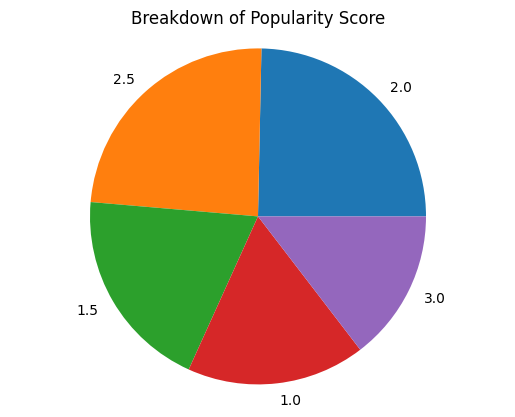

In [4114]:
counts = df2["popularity"].value_counts()
plt.pie(counts, labels=counts.index)
plt.title("Breakdown of Popularity Score")
plt.axis('equal')

### Evaluating Popularity Score in Each Region for Each Room Type

In [4115]:
popularity_by_region = df2.groupby(["room_type", "region"])["popularity"].mean().reset_index()
print(popularity_by_region)

          room_type     region  popularity
0   Entire home/apt    Central    2.244488
1   Entire home/apt  Northeast    2.004558
2   Entire home/apt  Northwest    2.039251
3   Entire home/apt  Southeast    2.042784
4   Entire home/apt  Southwest    2.101175
5        Hotel room    Central    1.791159
6        Hotel room  Northeast    1.696078
7        Hotel room  Northwest    1.797521
8        Hotel room  Southeast    1.843137
9        Hotel room  Southwest    1.599359
10     Private room    Central    1.793998
11     Private room  Northeast    1.726914
12     Private room  Northwest    1.843805
13     Private room  Southeast    1.693654
14     Private room  Southwest    1.729054
15      Shared room    Central    1.661017
16      Shared room  Northeast    1.534722
17      Shared room  Northwest    1.800926
18      Shared room  Southeast    1.548780
19      Shared room  Southwest    1.714286


Text(0.5, 1.0, 'Popularity Score by Region and Room Type')

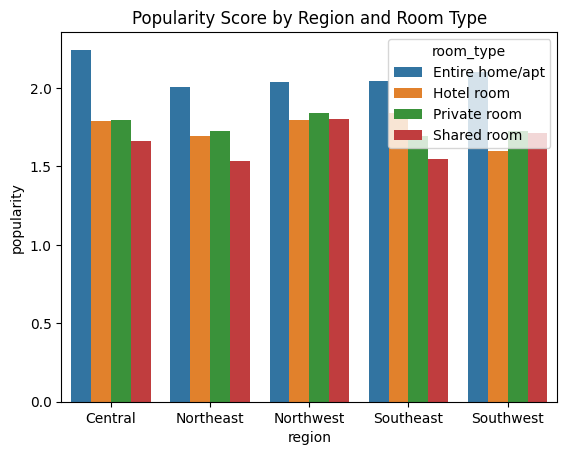

In [4116]:
sns.barplot(data=popularity_by_region, x="region", y="popularity", hue="room_type")
plt.title("Popularity Score by Region and Room Type")

### Justify Using Median for Each Room in Each Region

<Axes: xlabel='price', ylabel='Count'>

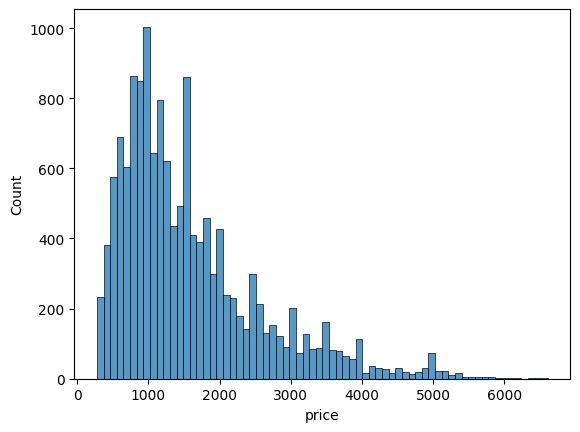

In [4117]:
sns.histplot(df2["price"])
# skewed to the right

In [4118]:
mean_price = df["price"].mean()
median_price = df["price"].median()
print(f"Mean: {mean_price}, Median: {median_price}")
# mean and median is substantially different

Mean: 3217.906894594083, Median: 1429.0


In [4119]:
# perform kruskal wallis test to determin whether median prices differ across regions and within room types

def kruskal_wallis(room):
    central = df2[(df2["room_type"] == room) & (df2["region"] == "Central")]["price"]
    ne = df2[(df2["room_type"] == room) & (df2["region"] == "Northeast")]["price"]
    nw = df2[(df2["room_type"] == room) & (df2["region"] == "Northwest")]["price"]
    se = df2[(df2["room_type"] == room) & (df2["region"] == "Southeast")]["price"]
    sw = df2[(df2["room_type"] == room) & (df2["region"] == "Southwest")]["price"]

    stat, p_val = kruskal(central, ne, nw, se, sw)
    print(f"Kruskal-Wallis Test for {room}", stat, p_val)

In [4120]:
kruskal_wallis("Entire home/apt")
kruskal_wallis("Private room")
kruskal_wallis("Hotel room")
kruskal_wallis("Shared room")

Kruskal-Wallis Test for Entire home/apt 1426.9111186791906 1.0096310900428839e-307
Kruskal-Wallis Test for Private room 346.533292834995 9.828015590055132e-74
Kruskal-Wallis Test for Hotel room 74.22792060016485 2.901990038792001e-15
Kruskal-Wallis Test for Shared room 41.34147400524278 2.2839503801374263e-08


- all pval is <0.05 --> there is significant differences in the price distributions among the groups (room types in each region)
- supports idea that median represents meaningful differences across groups

In [4121]:
price_medians = df.groupby(["room_type", "region"])["price"].median().reset_index()
combined = popularity_by_region.merge(price_medians, on=["room_type", "region"])
print(combined)

          room_type     region  popularity   price
0   Entire home/apt    Central    2.244488  1829.0
1   Entire home/apt  Northeast    2.004558  1200.0
2   Entire home/apt  Northwest    2.039251  1200.0
3   Entire home/apt  Southeast    2.042784  1000.0
4   Entire home/apt  Southwest    2.101175  1438.0
5        Hotel room    Central    1.791159  2021.5
6        Hotel room  Northeast    1.696078  1490.0
7        Hotel room  Northwest    1.797521  1295.5
8        Hotel room  Southeast    1.843137  1295.0
9        Hotel room  Southwest    1.599359  1700.0
10     Private room    Central    1.793998  1634.0
11     Private room  Northeast    1.726914   950.0
12     Private room  Northwest    1.843805  1364.0
13     Private room  Southeast    1.693654   992.0
14     Private room  Southwest    1.729054  1286.0
15      Shared room    Central    1.661017   574.0
16      Shared room  Northeast    1.534722   765.0
17      Shared room  Northwest    1.800926   550.0
18      Shared room  Southeast 

In [4122]:
# perform spearman rank correlation to assess the relationship between popularity score and price for each room_type

# split dataset into room types
eha = combined[combined["room_type"] == "Entire home/apt"]
hr = combined[combined["room_type"] == "Hotel room"]
pr = combined[combined["room_type"] == "Private room"]
sr = combined[combined["room_type"] == "Shared room"]

In [4123]:
# spearmann correlation test 

def correlation(df):
    corr, p_value = spearmanr(df["popularity"], df["price"])
    print(f"Spearman Correlation: {corr}")
    print(f"P-value: {p_value}")

In [4124]:
correlation(eha)
correlation(hr)
correlation(pr)
correlation(sr)

Spearman Correlation: 0.6668859288553501
P-value: 0.21889398131323168
Spearman Correlation: -0.7
P-value: 0.1881204043741873
Spearman Correlation: 0.7999999999999999
P-value: 0.10408803866182788
Spearman Correlation: 0.0
P-value: 1.0
